In [1]:
%reload_ext autoreload
%autoreload 2

from datetime import datetime
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import numpy as np
import torch
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_write, pickle_read
from dataset.station_dataset import GroundstationDataset
from dataset.normalization import ZeroMinMax
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_scatter
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
import cartopy.feature as cf
import matplotlib 
# matplotlib.rc('xtick', labelsize=12) 
# matplotlib.rc('ytick', labelsize=12) 
# matplotlib.rc('axes', labelsize=12, titlesize=25) 
# matplotlib.rc('legend', fontsize=16)


FIGSIZE=(13.33,7.5)
DPI=300

# List DL models

In [2]:
model_folders = {
    'jup3gn3n':'../irradiance_estimation/train/SIS_point_estimation/jup3gn3n/', # SARAH3 emulator
    'hmobjerd':'../irradiance_estimation/train/SIS_point_estimation_groundstation/hmobjerd/', #  finetuned on 80 DWD groundstations
    '4j9y9tqb': '../irradiance_estimation/train/SIS_point_estimation_groundstation/4j9y9tqb/', # finetuned on METEOSWISS
    'hg90jzjy': '../irradiance_estimation/train/SIS_point_estimation_groundstation/hg90jzjy/', # finetuned on IEA-PVPS
    '6zy2qu70': '../irradiance_estimation/train/SIS_point_estimation_groundstation/6zy2qu70/', # DWD groundstations only
}

trans = {'jup3gn3n':'Emulator', # SARAH3 emulator
    'hmobjerd':'Finetuned\nDWD', #  trained on 80 DWD groundstations{}
    '4j9y9tqb': 'Finetuned\nDWD ->\nMETEOSWISS',
    'hg90jzjy': 'Finetuned\nDWD ->\nMETEOSWISS\n-> IEA-PVPS',
    '6zy2qu70': 'Trained only on\nDWD',
    }

# Baseline predictions

In [3]:
# BSRN
baseline_BSRN = pickle_read('../irradiance_estimation/inference/BSRN_baseline_predictions.pkl')
#KNMI
baseline_knmi = pickle_read('../irradiance_estimation/inference/KNMI_baseline_predictions.pkl')

#METEOSWISS
baseline_meteoswiss = pickle_read('../irradiance_estimation/inference/METEOSWISS_baseline_predictions.pkl')
#DWD
baseline_dwd = pickle_read('../irradiance_estimation/inference/DWD_baseline_predictions.pkl')

train_id = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]
valid_id = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]
train_id = [i for i in train_id]
valid_id = [i for i in valid_id]

baseline_dwd_train = {k:v for k,v in baseline_dwd.items() if k in train_id}
baseline_dwd_valid = {k:v for k,v in baseline_dwd.items() if k in valid_id}

baseline_prediction = {'IEA-PVPS':baseline_BSRN,  
                       'DWD train':baseline_dwd_train, 
                       'DWD validation':baseline_dwd_valid, 
                       'KNMI':baseline_knmi,
                       'METEOSWISS':baseline_meteoswiss
                       }

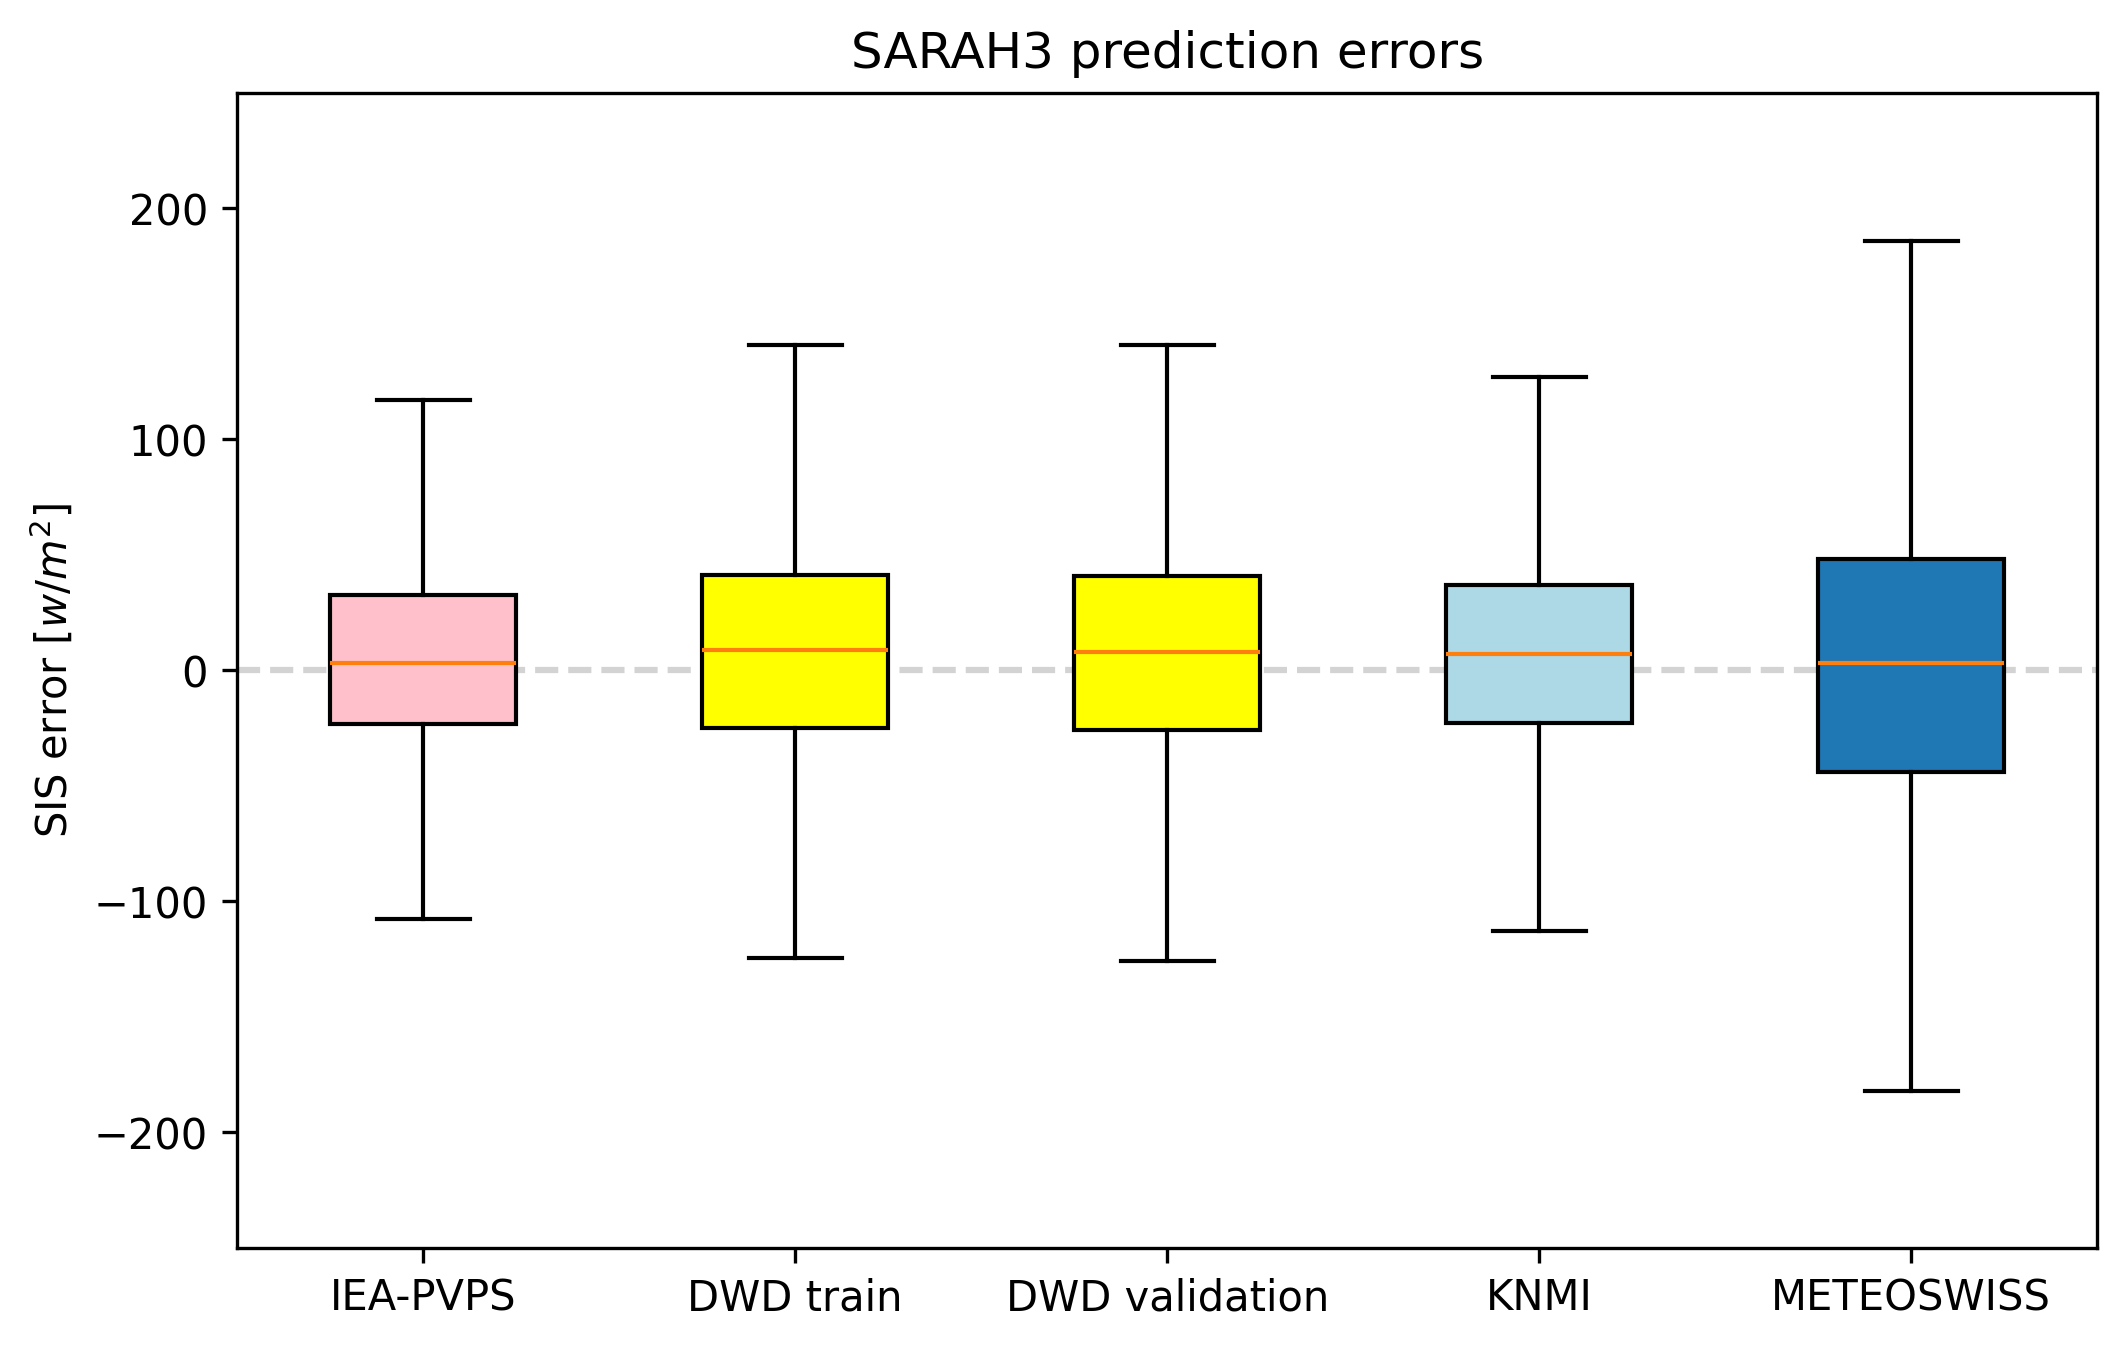

In [4]:
fig, axes = plt.subplots(1,1, figsize=(8,5), dpi=DPI)

errors = {}
for baseline_nm, baseline_pred in baseline_prediction.items():
    y = np.concatenate([pred['y'] for pred in baseline_pred.values()])
    y_hat = np.concatenate([pred['y_hat'] for pred in baseline_pred.values()])
    
    nans = np.isnan(y_hat)
    y = y[~nans]
    y_hat = y_hat[~nans]

    errors[baseline_nm] = y_hat - y
    # prediction_error_plot(y, y_hat, title=f'{baseline_nm}')

bplot1 = axes.boxplot(errors.values(), 
                      labels= errors.keys(), 
                      sym='',
                     patch_artist=True,  # fill with color
                     )
axes.axhline(0, color = 'lightgrey', linestyle='--', zorder=-2)

axes.set_ylim(-250, 250)
axes.set_title('SARAH3 prediction errors')
axes.set_ylabel('SIS error $[w/m^2]$')
fig.savefig('sarah3_errors.png', dpi=DPI, bbox_inches='tight')

colors = ['pink', 'yellow', 'yellow', 'lightblue']
for bplot in (bplot1,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.savefig('sarah3_errors.png', dpi=DPI, bbox_inches='tight')


# Plot groundstations

In [5]:
bsrn = xarray.open_dataset('../IEA_PVPS/index.nc')
bsrn['station'] = bsrn.station_name

bsrn = bsrn.sel(station=[str(x) for x in baseline_BSRN.keys()])

dwd = xarray.open_dataset('../DWD/netcdf/DWD_SOLAR_index.nc')
dwd = dwd.sel(station_id=[int(x) for x in baseline_dwd.keys()])

knmi = xarray.open_dataset('../KNMI/nc/index.nc')
knmi = knmi.sel(station=list(baseline_knmi.keys()))

meteoswiss = xarray.open_zarr('../METEOSWISS/ground_station_data.zarr')
meteoswiss =meteoswiss.rename_vars({'x':'lon', 'y':'lat'}).set_coords(['lon', 'lat'])
meteoswiss = meteoswiss.sel(station_name=list(baseline_meteoswiss.keys()))

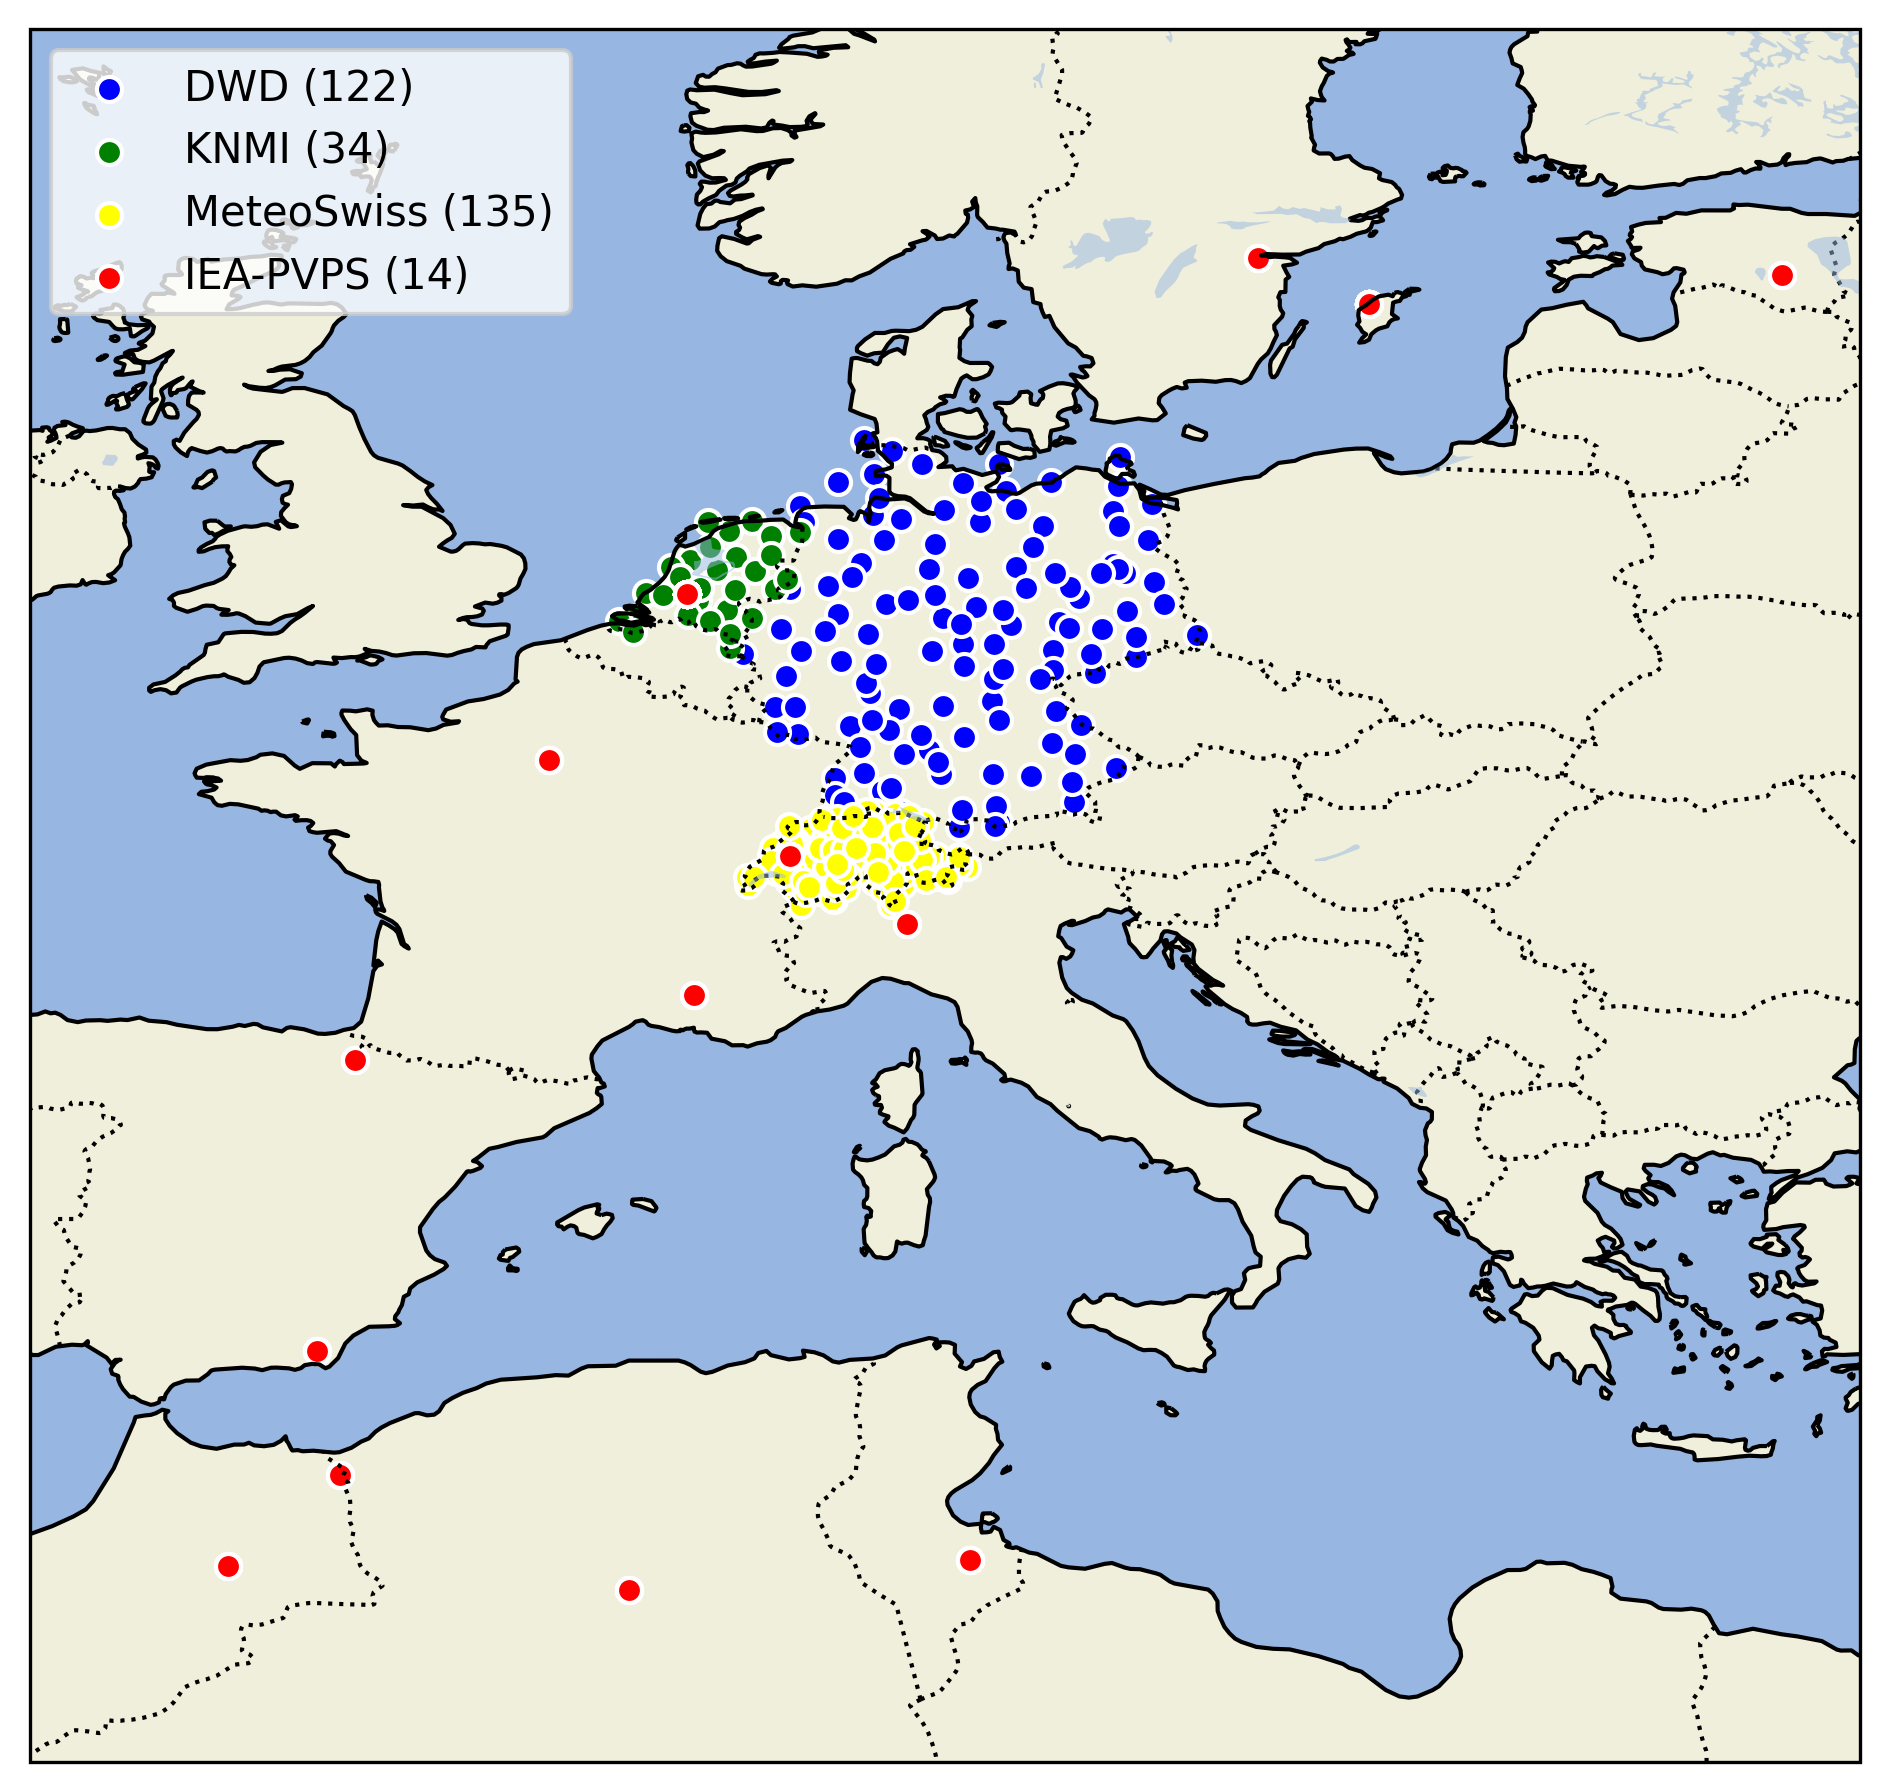

In [6]:

fig = plt.figure(figsize=(13.33,7.5), dpi=300)
dwd.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
knmi.plot.scatter(x='lon', y='lat', c='g', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
meteoswiss.isel(time=0).plot.scatter(x='lon', y='lat', c='yellow', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a= bsrn.plot.scatter(x='longitude', y='latitude', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())

# index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.set_extent([-8, 28, 29, 62])
ax = a.axes
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.legend([ f'DWD ({len(dwd.station_id)})', 
           f'KNMI ({len(knmi.station)})', 
           f'MeteoSwiss ({len(meteoswiss.station_name)})',
           f'IEA-PVPS ({len(bsrn.station)})',
           ], loc='best')
plt.show()
fig.savefig('Pyranometer_locations.png')


# Model predictions

In [7]:
minmax = ZeroMinMax()

model_predictions = {}

for model_nm, fol in model_folders.items():
    inference_fn = fol + 'inference/'
    
    bsrn_pred = pickle_read(inference_fn + 'IEA_PVPS_new_predictions.pkl')
    dwd_train = pickle_read(inference_fn + 'DWD_train_new_predictions.pkl')
    dwd_valid = pickle_read(inference_fn + 'DWD_valid_new_predictions.pkl')
    knmi = pickle_read(inference_fn + 'KNMI_new_predictions.pkl')
    meteoswiss = pickle_read(inference_fn + 'METEOSWISS_new_predictions.pkl')

        
    model_predictions[model_nm] = {'IEA-PVPS':bsrn_pred, 
                                   'DWD train':dwd_train, 
                                   'DWD validation':dwd_valid,
                                   'KNMI':knmi,
                                    'METEOSWISS':meteoswiss
                                    }


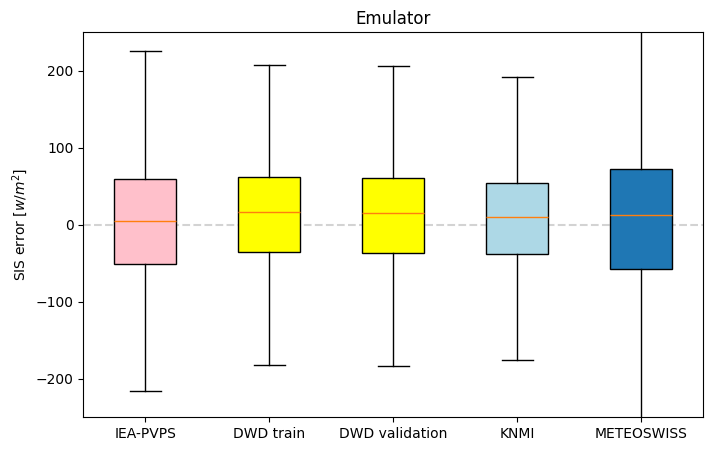

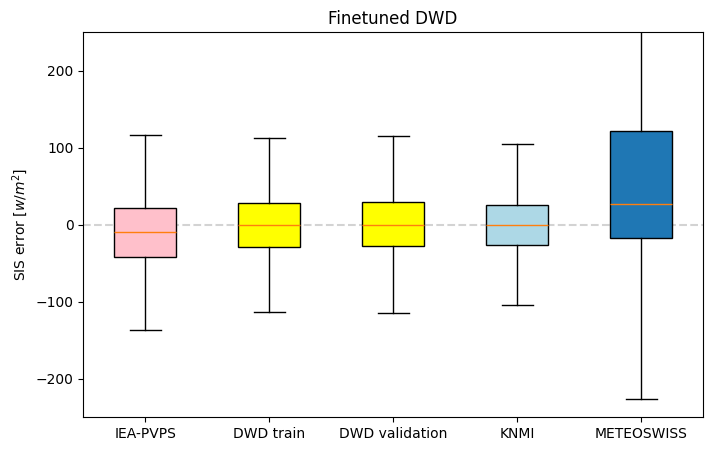

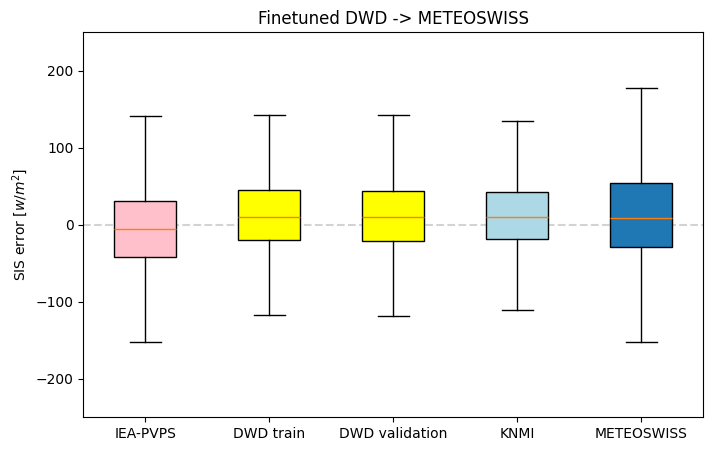

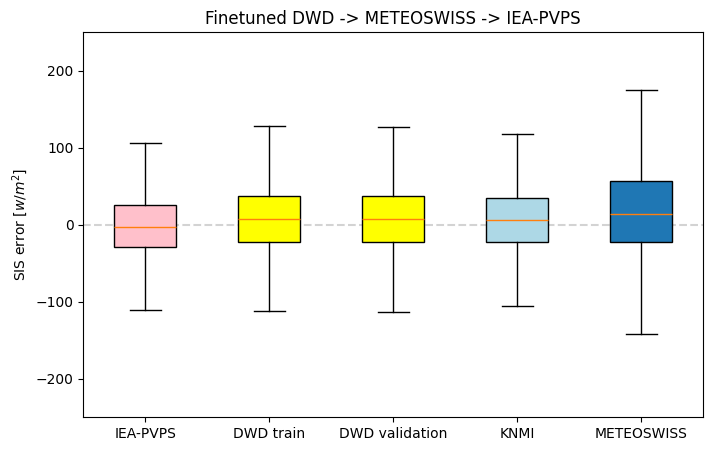

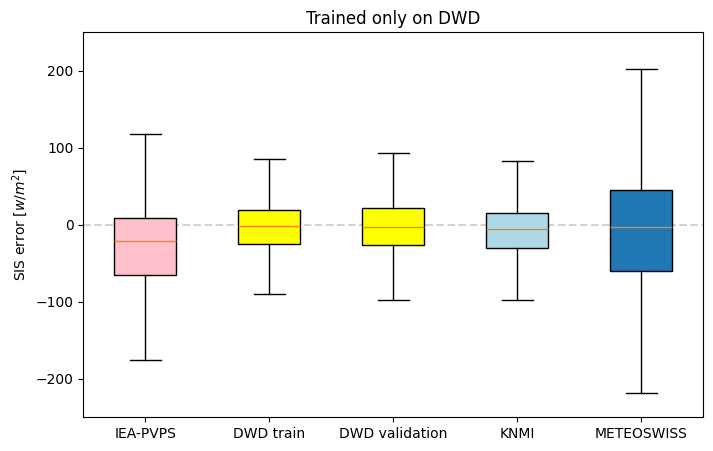

In [8]:
for model_nm, predictions in model_predictions.items():
    
    fig, axes = plt.subplots(1,1, figsize=(8,5))

    errors = {}
    for nm, pred_set in predictions.items():
        y = np.concatenate([p.SIS.values for p in pred_set.values()])
        y_hat = np.concatenate([p.y_hat.values for p in pred_set.values()])
        
        notnan = ~np.isnan(y_hat)
        y=y[notnan]
        y_hat=y_hat[notnan]
        
        errors[nm] = y_hat - y
        # prediction_error_plot(y, y_hat, title=f'{nm}')
    
    bplot1 = axes.boxplot(errors.values(), 
                          labels= errors.keys(), 
                          sym='',
                         patch_artist=True,  # fill with color
                         )

    axes.set_title(trans[model_nm].replace("\n", " "))
    axes.set_ylabel('SIS error $[w/m^2]$')
    axes.axhline(0, color = 'lightgrey', linestyle='--', zorder=-2)
    axes.set_ylim(-250, 250)

    colors = ['pink', 'yellow', 'yellow', 'lightblue']
    for bplot in (bplot1,):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

    fig.savefig(f'errors_{model_nm}.png', dpi=DPI, bbox_inches='tight')

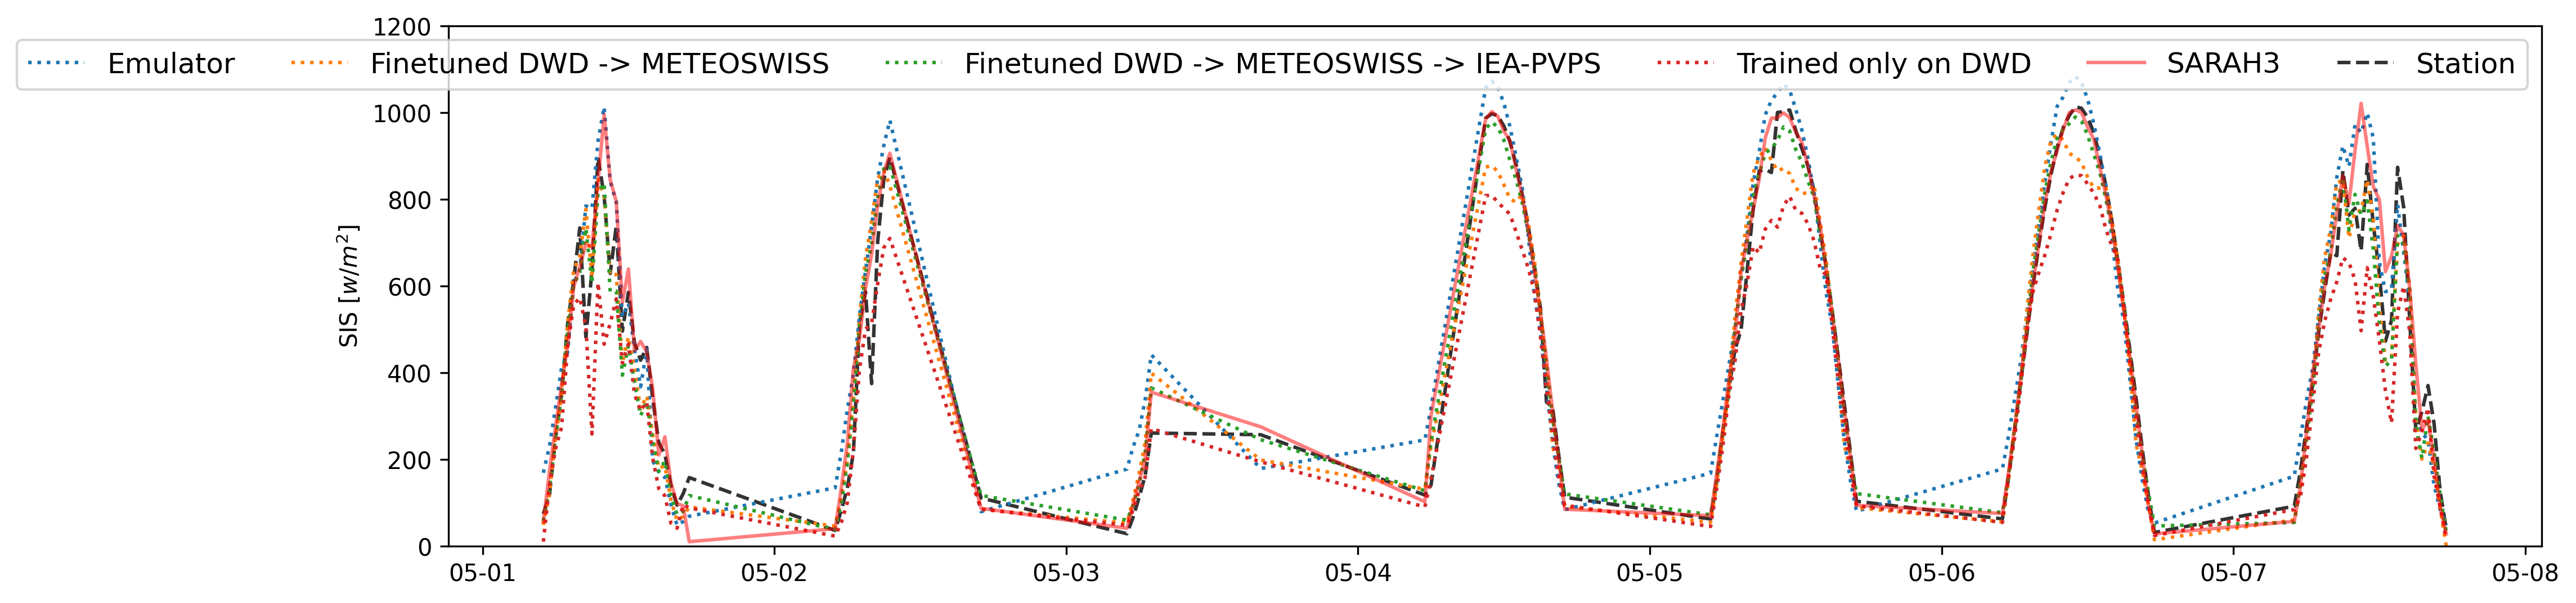

In [59]:
import matplotlib.dates as mdates
dt = datetime(2017, 5,1)
tdelta = pd.Timedelta(days=7)  # + 7 days
station_nm = 'TAT'
station_set = 'IEA-PVPS'


fig = plt.figure(figsize=(16,4), dpi=300)
for model_nm, predictions in model_predictions.items():
    if model_nm in ['hmobjerd', ]:
        continue

    pred_nm_set = predictions[station_set][station_nm]

    t = pred_nm_set['time']
    y_hat = pred_nm_set['y_hat']
    t = pd.DatetimeIndex(t)

    a = (t.date >= dt.date()) & (t.date < (dt.date() + tdelta))

    plt.plot(t[a], y_hat[a], ':', label=trans[model_nm].replace('\n',' '),)


pred = baseline_prediction[station_set][station_nm]
y_hat = pred['y_hat']
ds  = pred['combined']
ds['y_hat'] = (('time'), y_hat)
ds = ds.sel(time = slice(dt, dt + tdelta))
plt.plot(ds.time, ds.y_hat, 'r', alpha=.5, label='SARAH3')

plt.plot(ds.time, ds['SIS'], 'k--', label='Station', alpha=.8, zorder=-1)
plt.legend(fontsize=12, ncol=6, loc='best')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0, 1200)
plt.ylabel('SIS $[w/m^2]$')


os.makedirs('timeseries', exist_ok=True)
plt.savefig(f'timeseries/OUJ_{dt.strftime("%Y%m%d")}.png', dpi=300, bbox_inches='tight')

# boxplot total

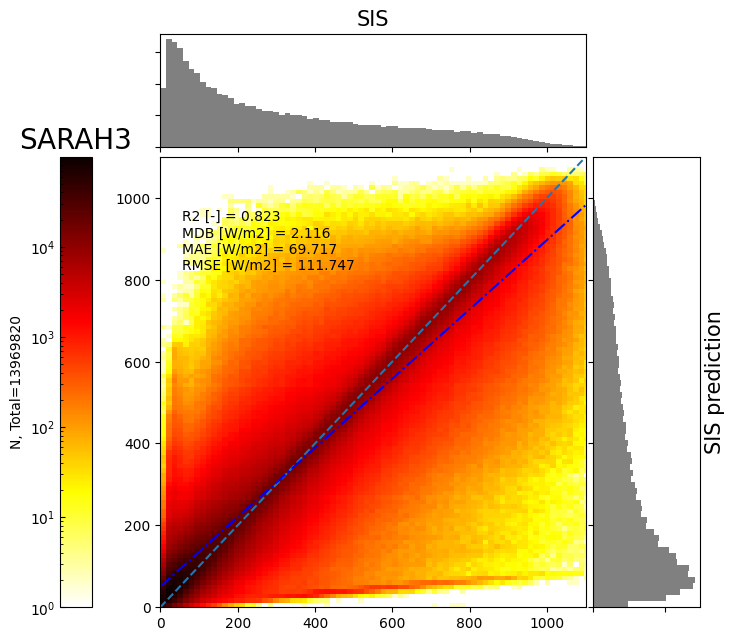

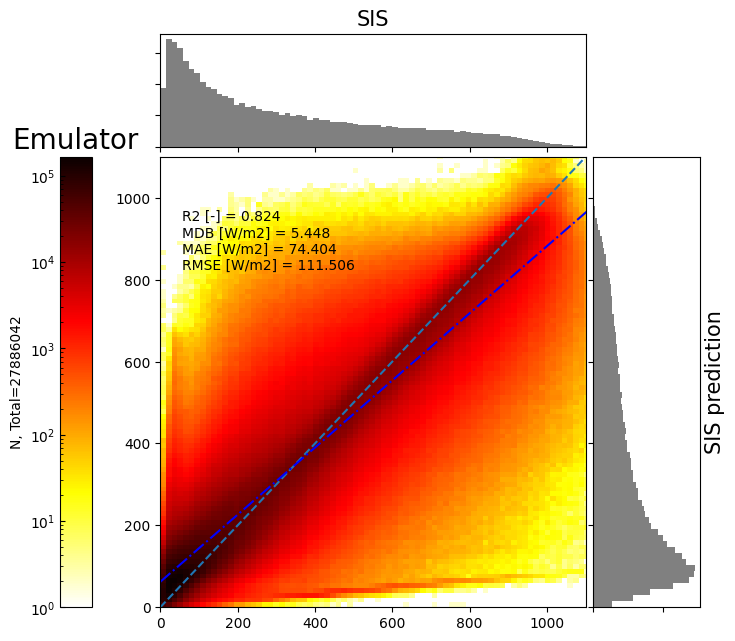

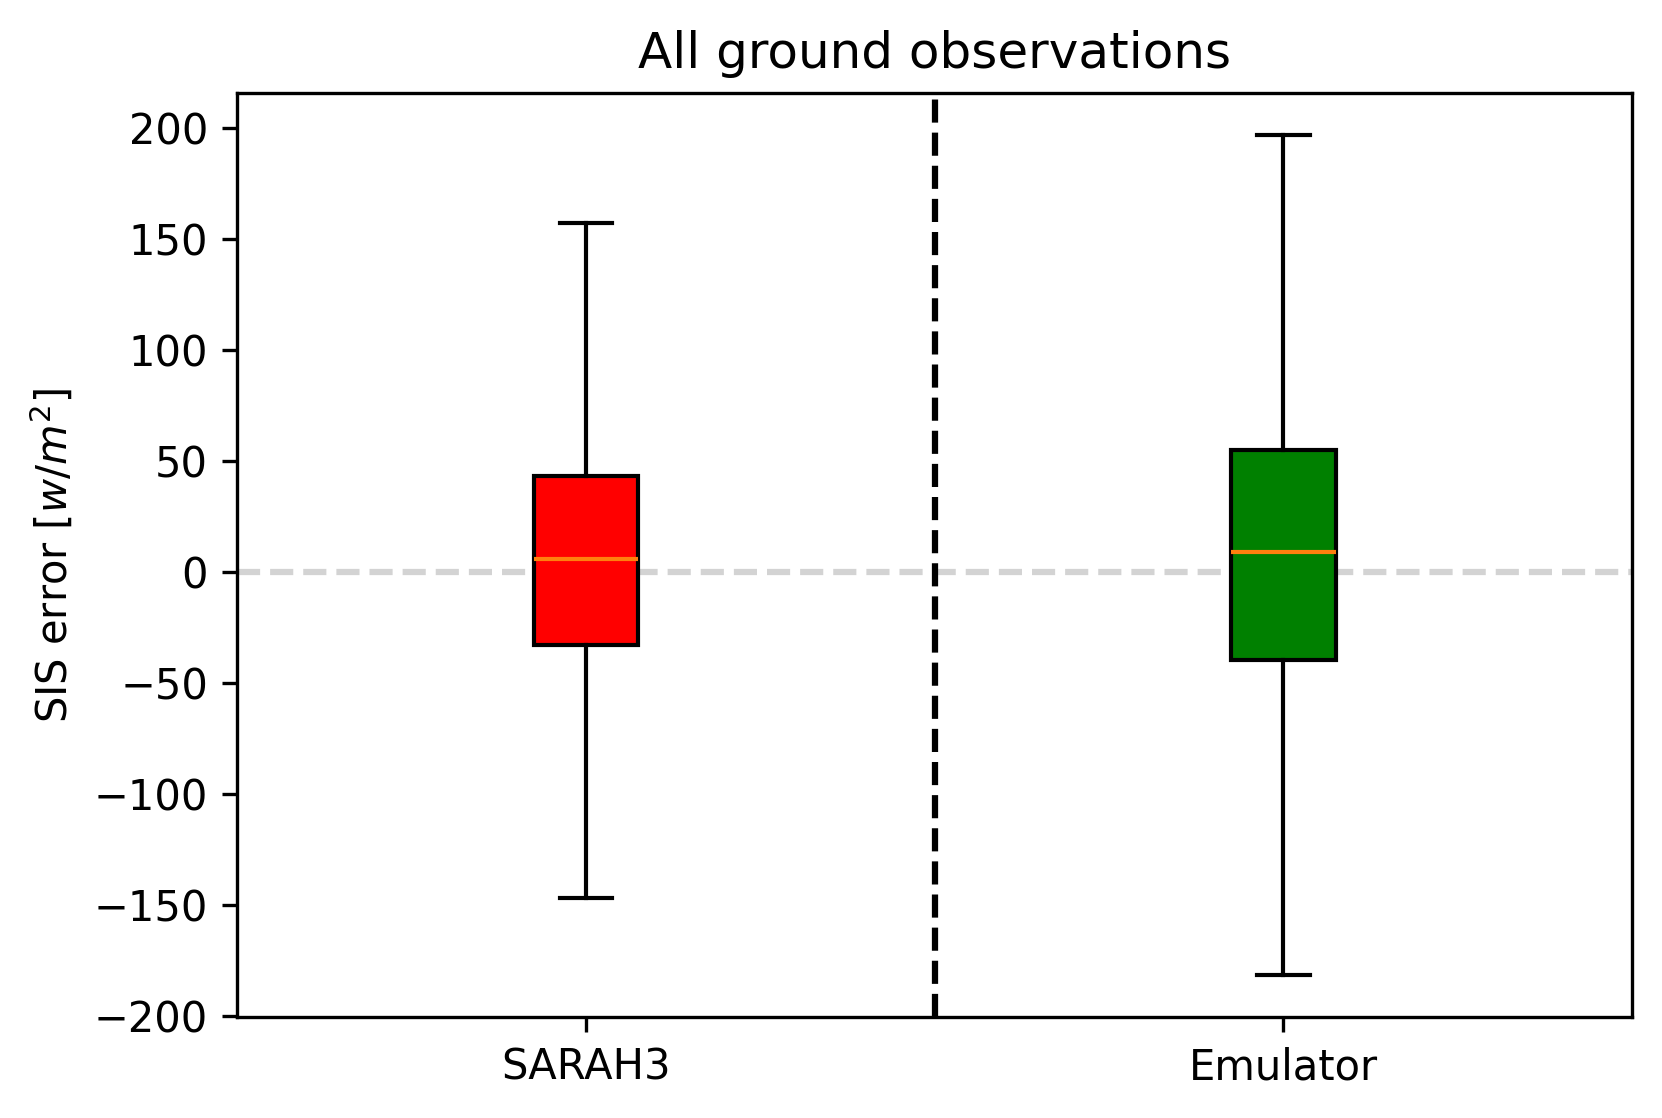

In [9]:

# inference_fn = '../train/SIS_point_estimation/4nbyae30/inference/'
# inference_fn = '../train/SIS_point_estimation_groundstation/pl86of1b/inference/'
# trans = {'jup3gn3n':'Emulator', # SARAH3 emulator
#     'hmobjerd':'Finetuned on\n DWD', #  trained on 80 DWD groundstations{}
#     '4j9y9tqb': 'Finetuned on\n DWD -> METEOSWISS',
#     'hg90jzjy': 'Finetuned on\n DWD -> METEOSWISS -> IEA-PVPS',
#     '6zy2qu70': 'Trained only on\n DWD',
#     }

model_code = 'jup3gn3n'
inference_fn= model_folders[model_code]


model_nm = trans[model_code]

ys = []
y_hats = []

notnan_d = {}
for set_nm, set in baseline_prediction.items():
    y = np.concatenate([p['y'].squeeze() for p in set.values()])
    y_hat = np.concatenate([p['y_hat'].squeeze() for p in set.values()])

    notnan = ~np.isnan(y_hat)
    # print(set_nm, len(y_hat), sum(np.isnan(y_hat)))

    notnan_d[set_nm] = notnan
    ys.append(y[notnan])
    y_hats.append(y_hat[notnan])

y_sarah = np.concatenate(ys)
y_hat_sarah = np.concatenate(y_hats)
model_predictions.keys()
for set_nm, set in model_predictions[model_code].items():
    y = np.concatenate([p['SIS'].values for p in set.values()])
    y_hat = np.concatenate([p['y_hat'].values for p in set.values()])

    # print(set_nm, len(y_hat), sum(np.isnan(y_hat)))
    notnan = notnan_d[set_nm]
    y_hat = y_hat[notnan]
    y = y[notnan]
    notnan2 = ~np.isnan(y_hat)
    y_hat = y_hat[notnan2]
    y = y[notnan2]
    
    ys.append(y)
    y_hats.append(y_hat)

y_dl = np.concatenate(ys)
y_hat_dl = np.concatenate(y_hats)

errors = {}
errors['SARAH3'] = y_hat_sarah - y_sarah
errors[model_nm] = y_hat_dl - y_dl

prediction_error_plot(y_sarah, y_hat_sarah, title='SARAH3')
prediction_error_plot(y_dl, y_hat_dl, title=model_nm)

fig, axes = plt.subplots(1,1, figsize=(6,4), dpi=DPI)
bplot1 = axes.boxplot(errors.values(), 
                      labels=errors.keys(), 
                    #   notch=True,
                    showfliers=False,
                      meanline=True,
                     patch_artist=True,  # fill with color
                     )
axes.set_ylabel('SIS error $[w/m^2]$')
axes.axvline(1.5, color = 'k', linestyle='--')
axes.axhline(0, color = 'lightgrey', linestyle='--', zorder=-2)
axes.set_title('All ground observations')

colors = ['red', 'green', 'lightgreen', 'lightblue']
for bplot in (bplot1,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.savefig(f'boxplot_all_ground_observations_{model_code}.png')

# Boxplot per set

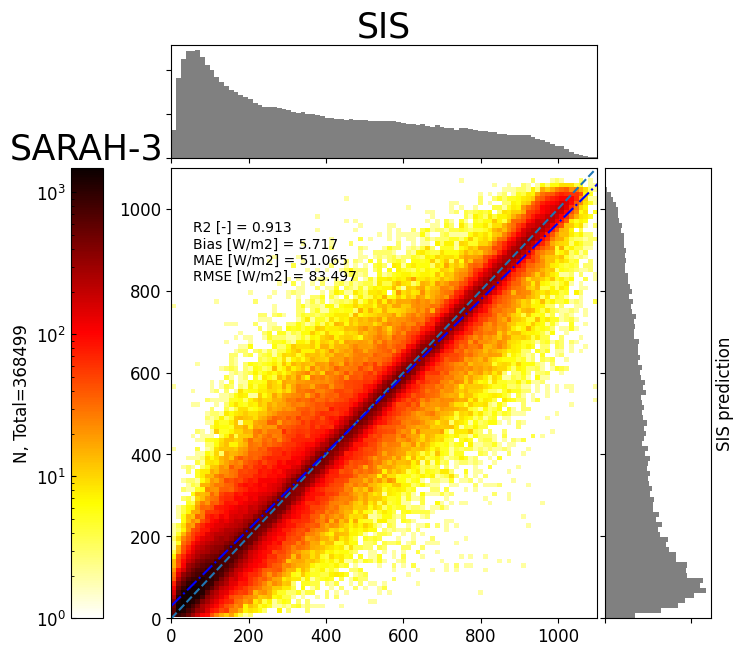

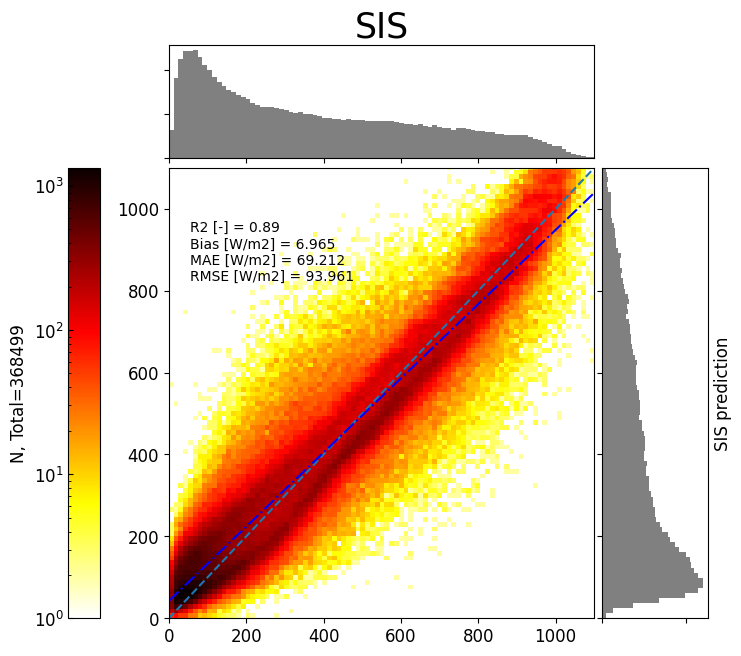

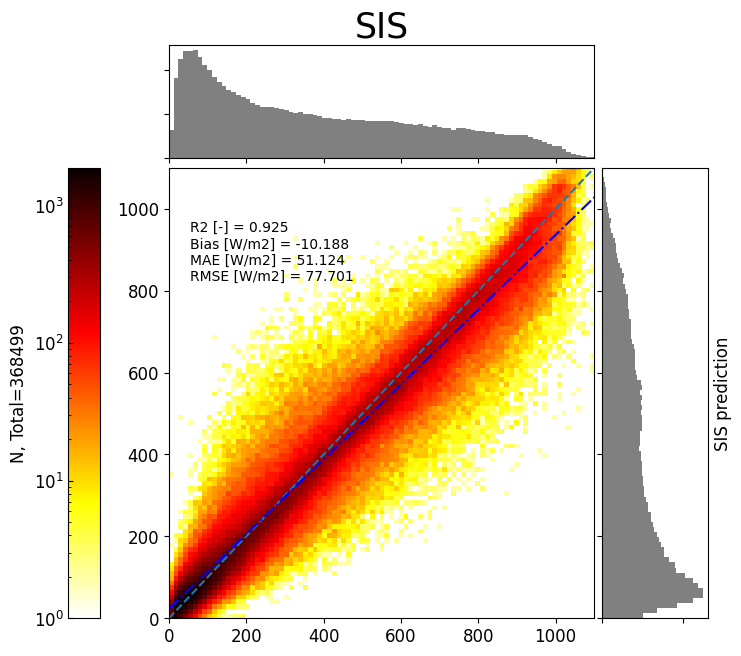

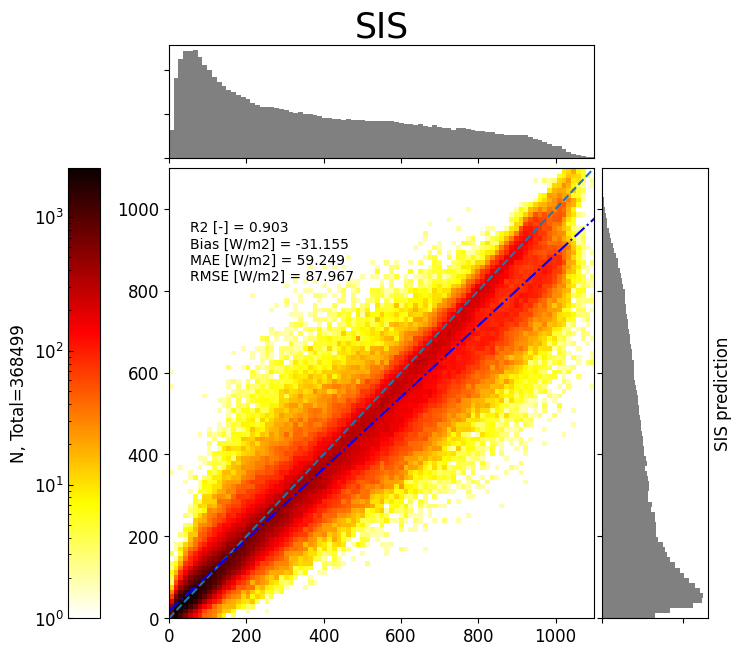

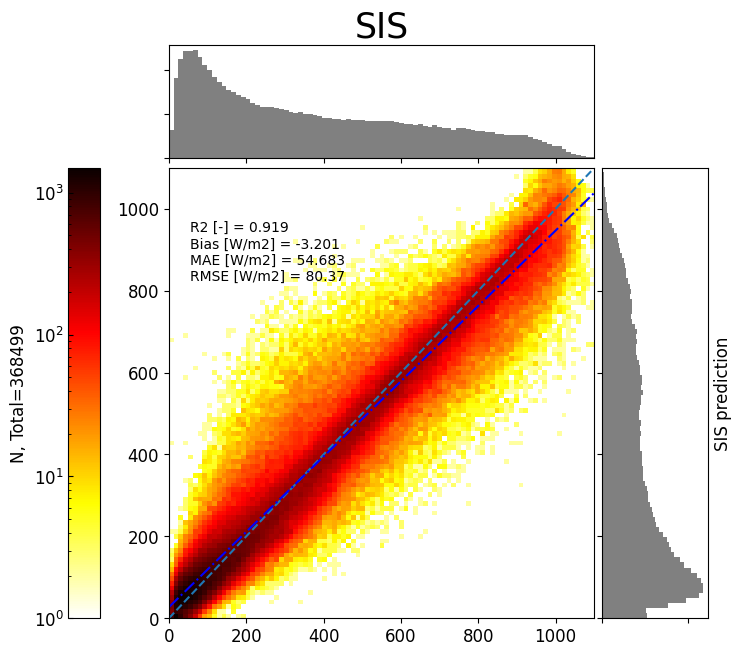

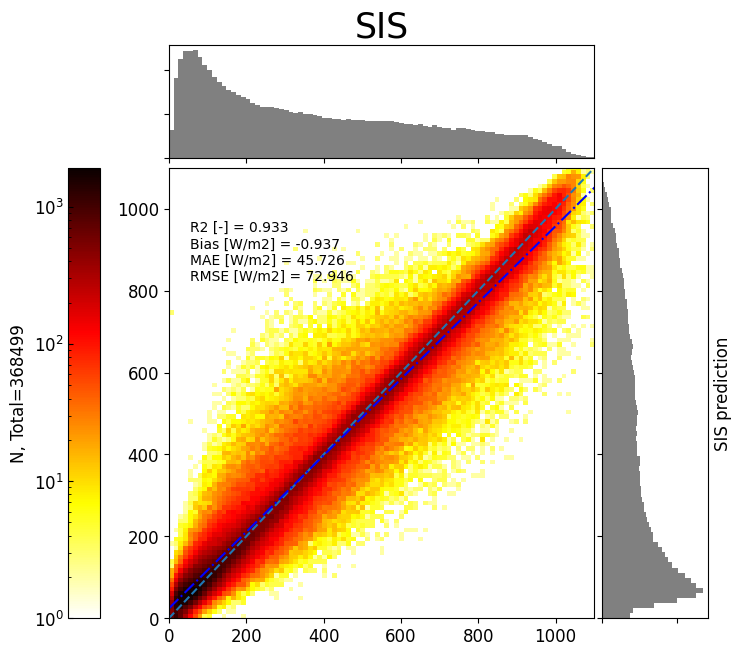

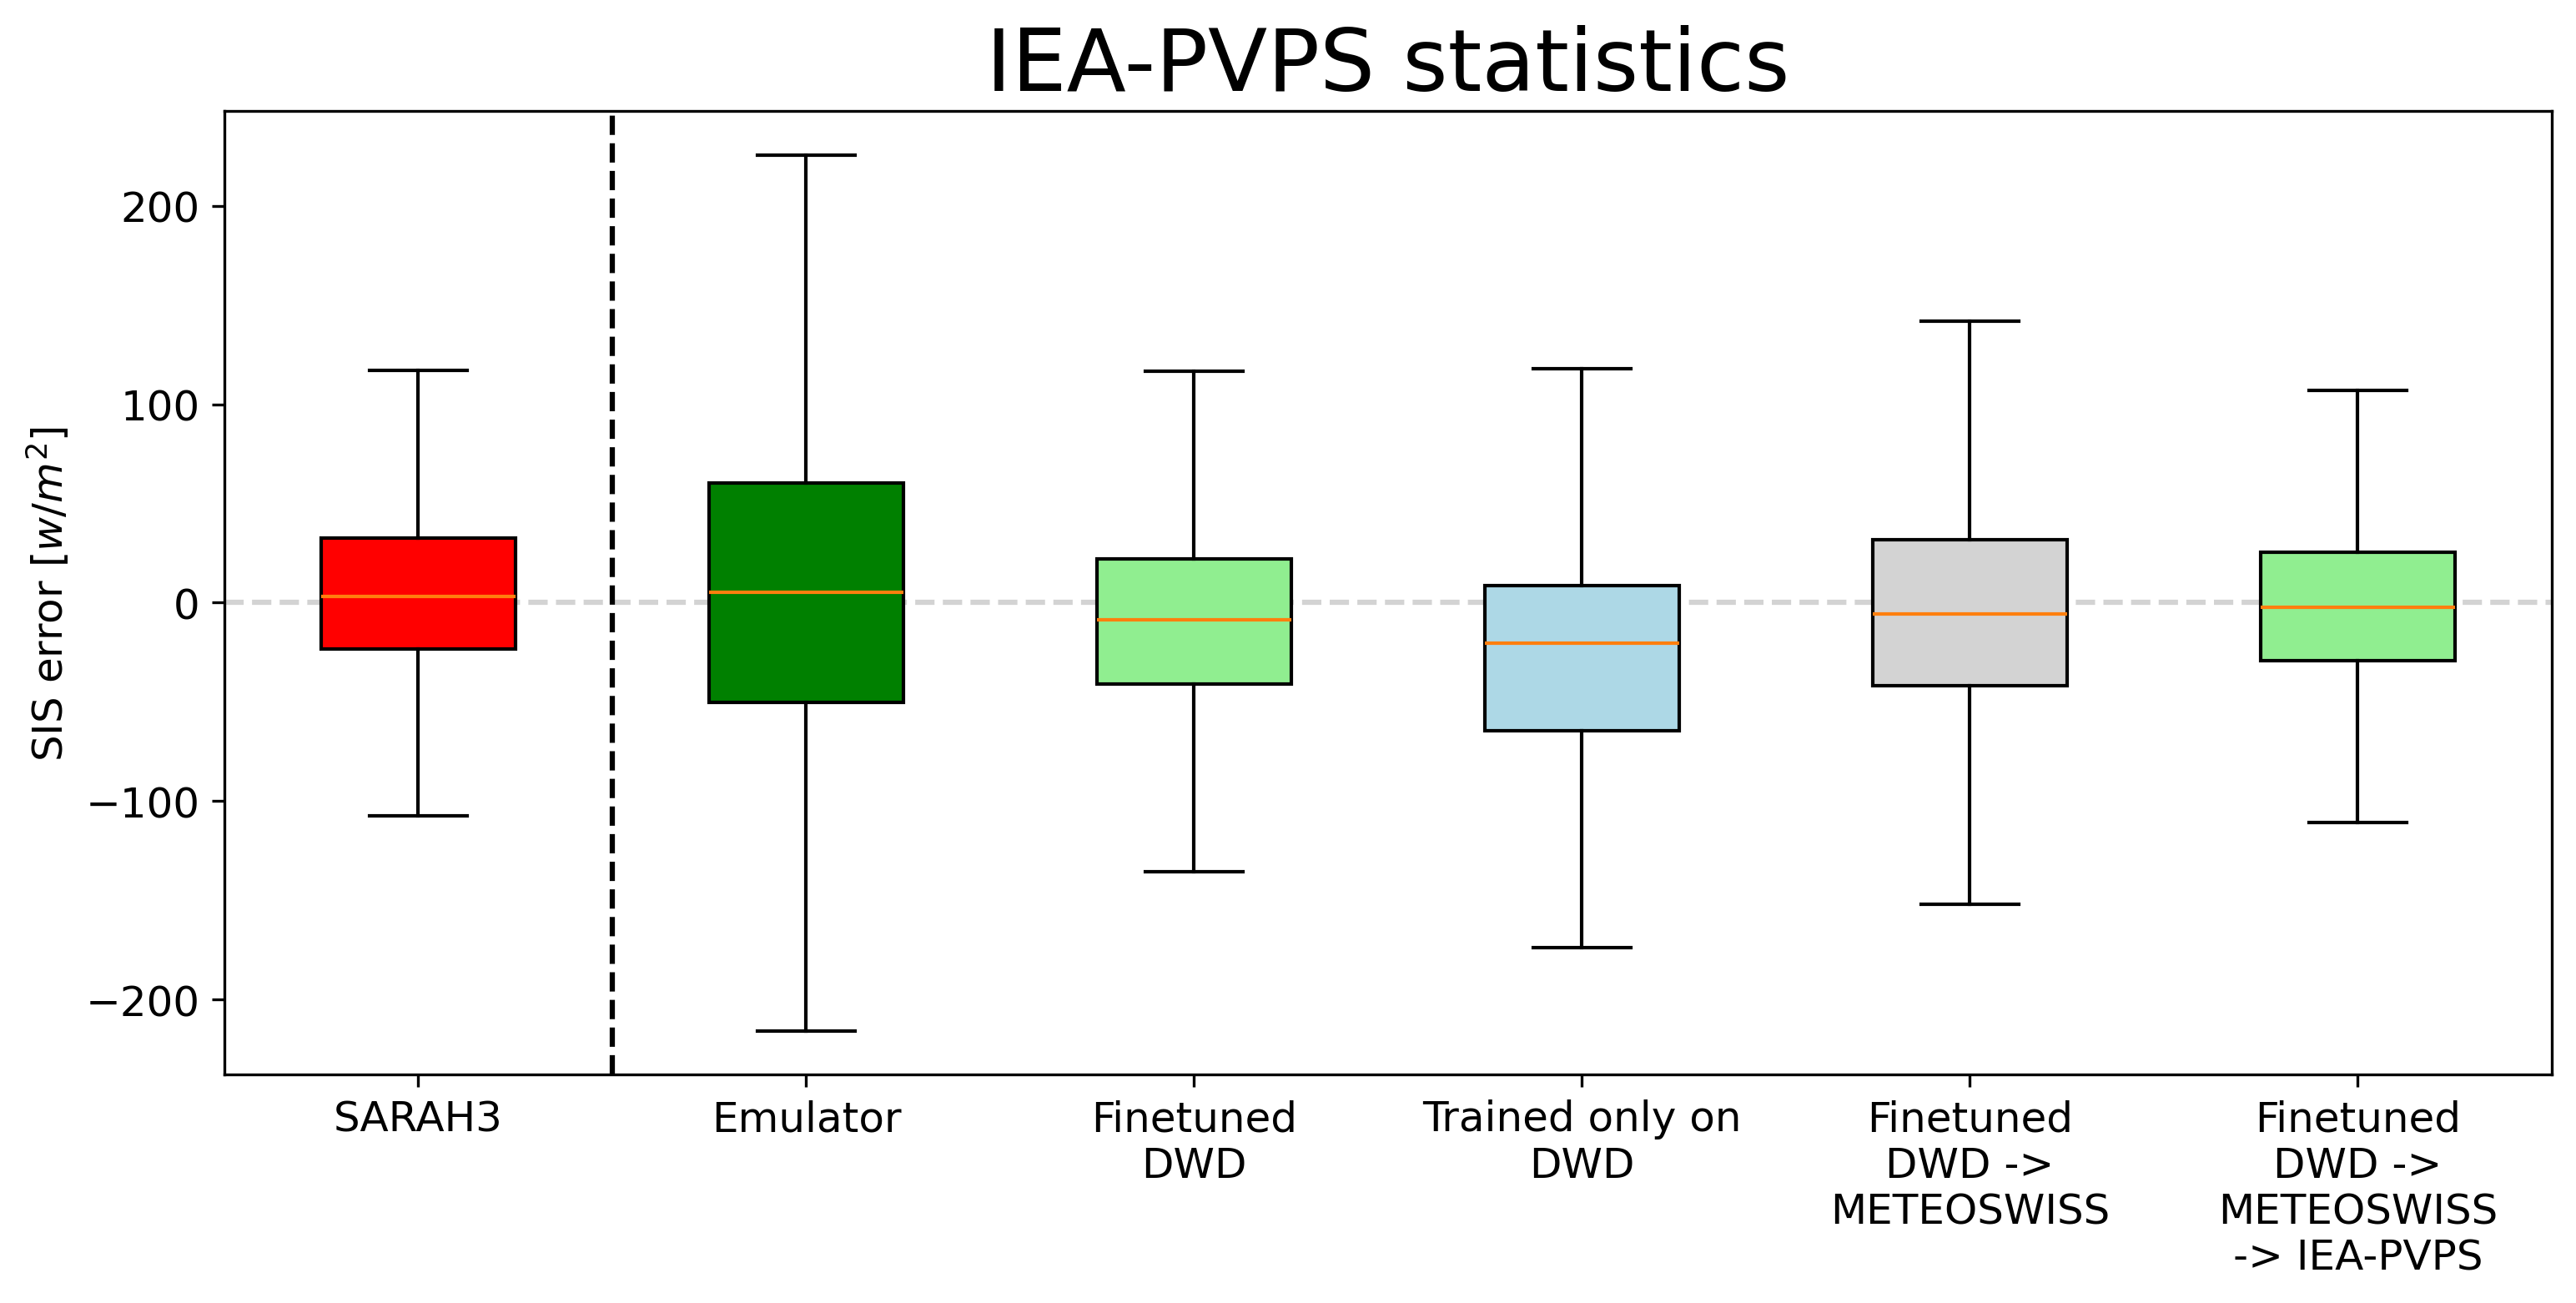

In [98]:
pyranometer_set = 'IEA-PVPS'

errors = {}
baseline_pred = baseline_prediction[pyranometer_set]
y = np.concatenate([pred['y'] for pred in baseline_pred.values()])
y_hat = np.concatenate([pred['y_hat'] for pred in baseline_pred.values()])
nans_sarah3 = ~np.isnan(y_hat)
y = y[nans_sarah3]
y_hat = y_hat[nans_sarah3]
errors['SARAH3'] = y_hat - y
fig = prediction_error_plot(y, y_hat, title='SARAH-3')
fig.savefig(f'qqplot_sarah3_{pyranometer_set}.png', dpi=DPI, bbox_inches='tight')

subset_models = ['jup3gn3n', 'hmobjerd', '6zy2qu70', '4j9y9tqb', 'hg90jzjy']
all_models = list(model_predictions.keys())

for model_nm in subset_models:
    
    predictions = model_predictions[model_nm]
    pred_set = predictions[pyranometer_set]
    y = np.concatenate([p['SIS'].squeeze() for p in pred_set.values()])
    y_hat = np.concatenate([p['y_hat'].squeeze() for p in pred_set.values()])
    y = y[nans_sarah3]
    y_hat = y_hat[nans_sarah3]

    notnan = ~np.isnan(y_hat)
    y=y[notnan]
    y_hat=y_hat[notnan]
    # print(sum(~notnan))

    errors[trans[model_nm]] = y_hat - y
    fig = prediction_error_plot(y, y_hat)
    fig.savefig(f'qqplot_{model_nm}_{pyranometer_set}.png', dpi=DPI, bbox_inches='tight')




fig, axes = plt.subplots(1,1, figsize=(12,5), dpi=DPI)
bplot1 = axes.boxplot(errors.values(), 
                      labels=errors.keys(), 
                    #   notch=True,
                    showfliers=False,
                      meanline=True,
                     patch_artist=True,  # fill with color
                     )

if pyranometer_set == 'BSRN':
  axes.set_title(f'IEA-PVPS statistics')
else:
  axes.set_title(f'{pyranometer_set} statistics')
axes.set_ylabel('SIS error $[w/m^2]$')
axes.axvline(1.5, color = 'k', linestyle='--')
axes.axhline(0, color = 'lightgrey', linestyle='--', zorder=-2)

colors = ['red', 'green', 'lightgreen', 'lightblue', 'lightgrey', 'lightgreen']
for bplot in (bplot1,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.set_size_inches(2+2*len(subset_models), 5)

if subset_models == all_models:
  fig.savefig(f'{pyranometer_set}_boxplot.png', dpi=DPI, bbox_inches='tight')
else:
  fig.savefig(f'{pyranometer_set}_boxplot_'+ '_'.join(subset_models) +'.png', dpi=DPI, bbox_inches='tight')




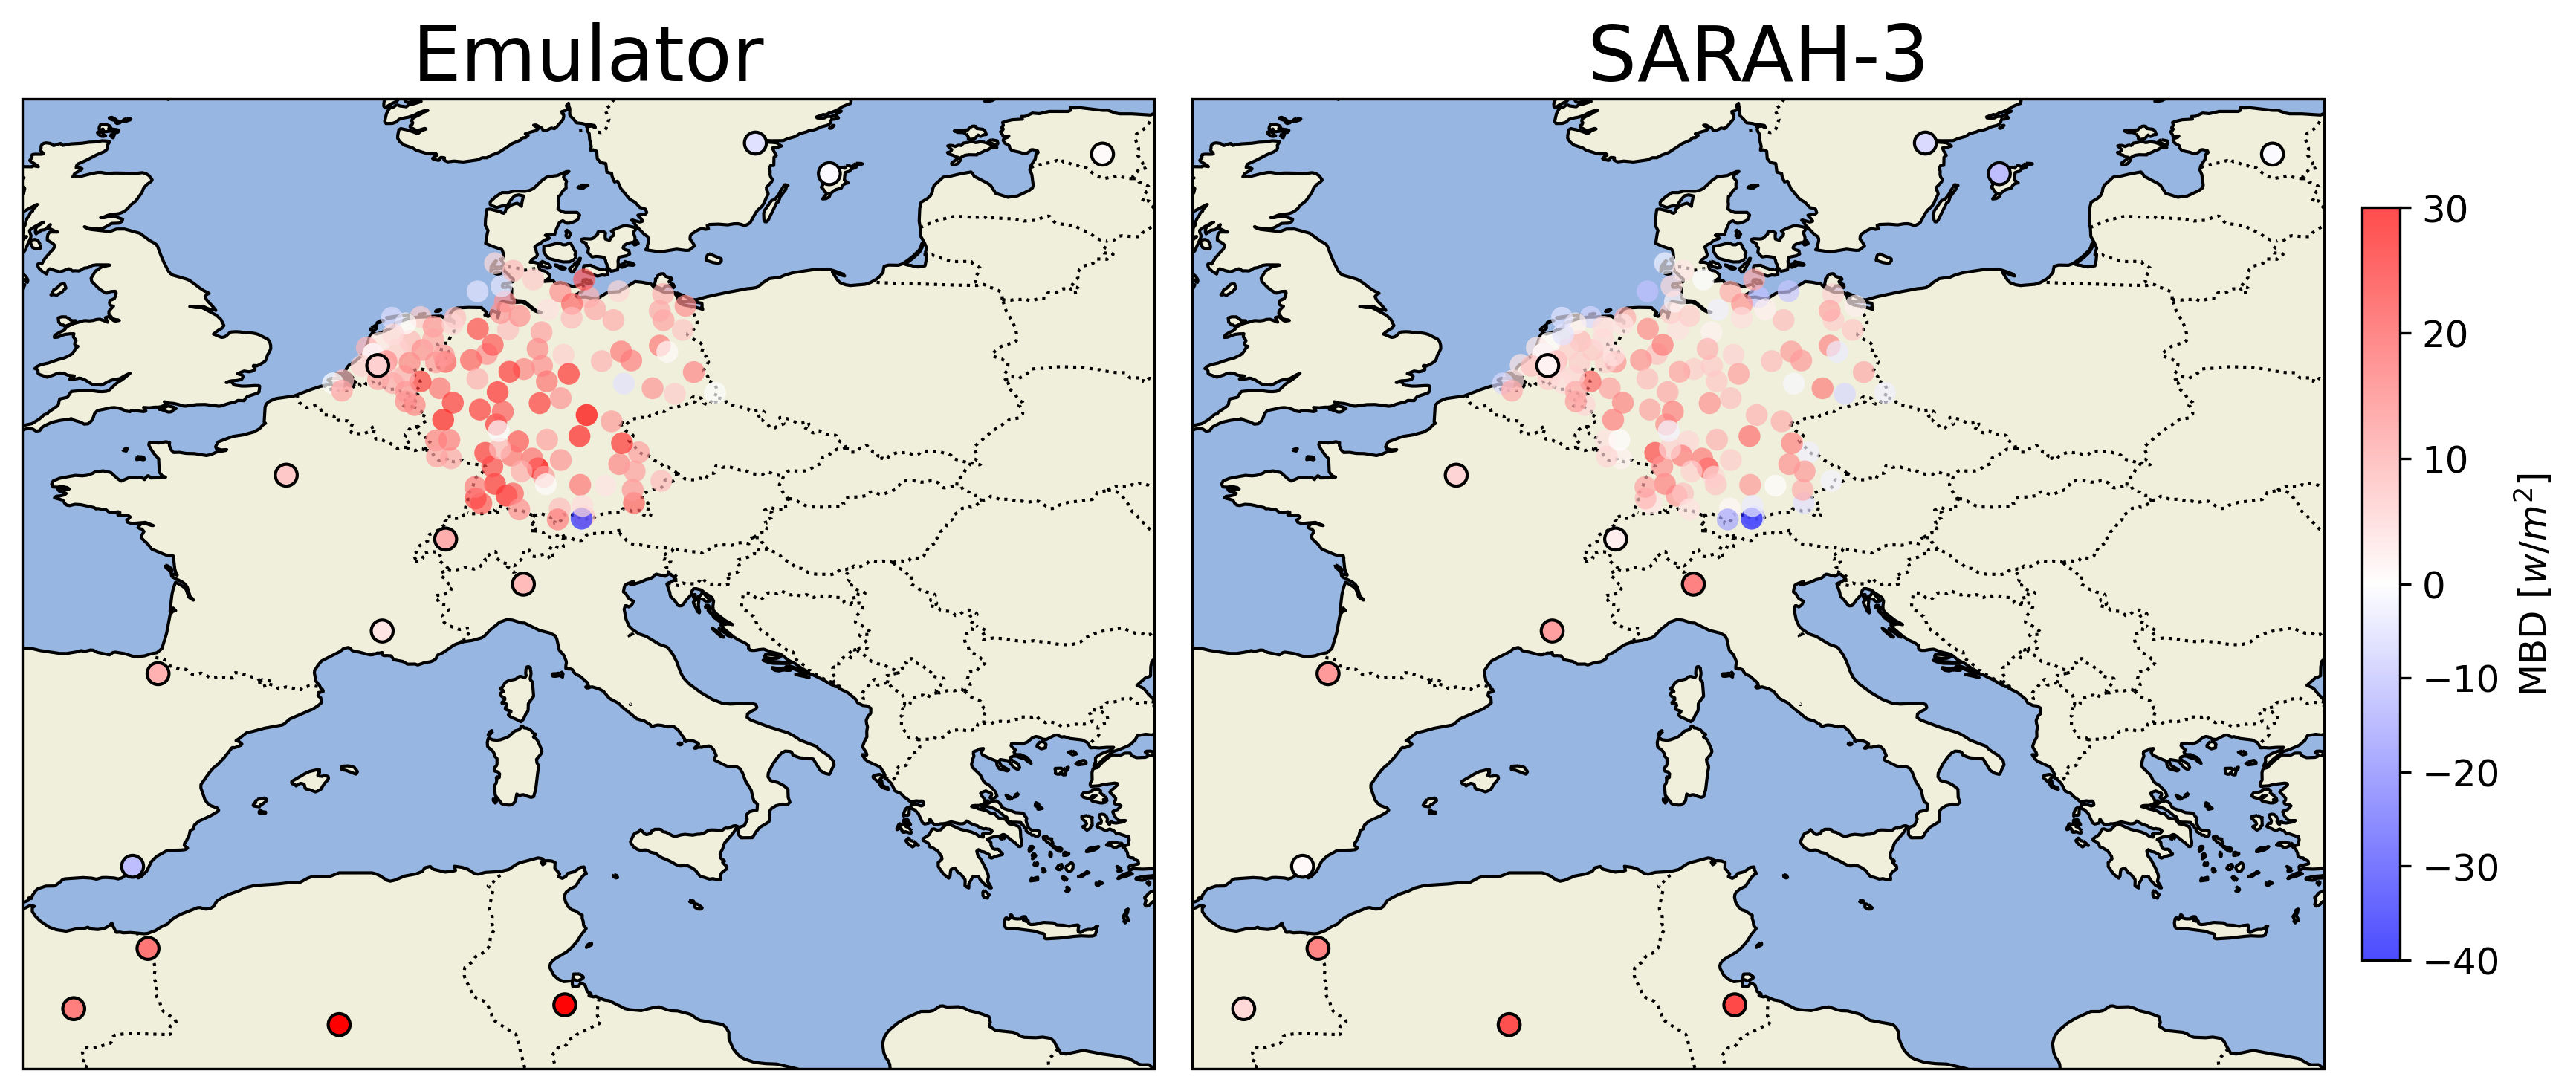

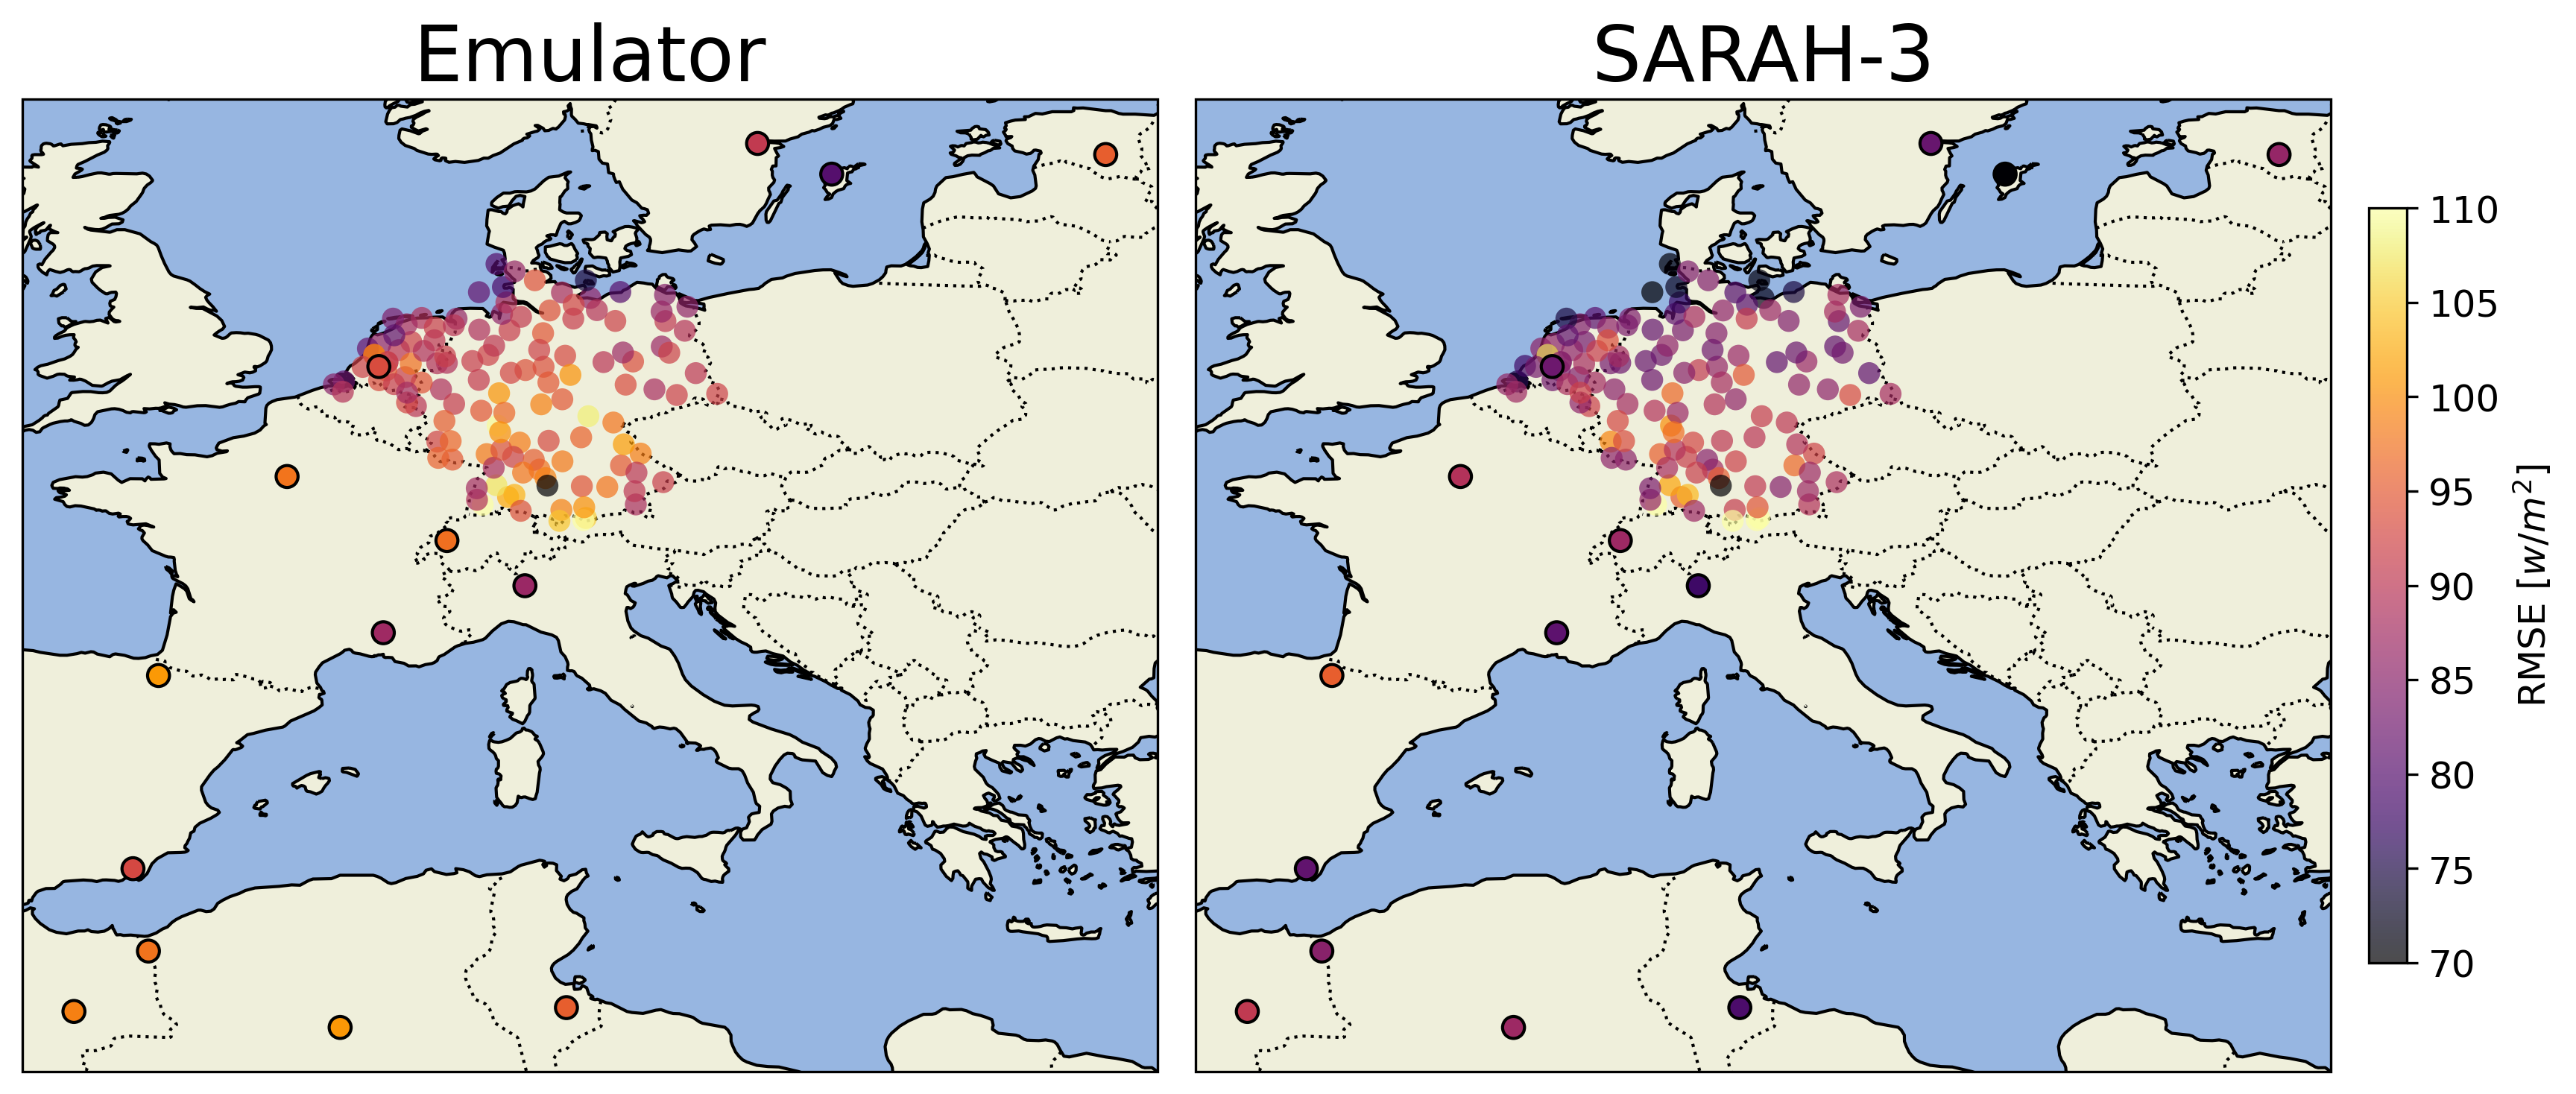

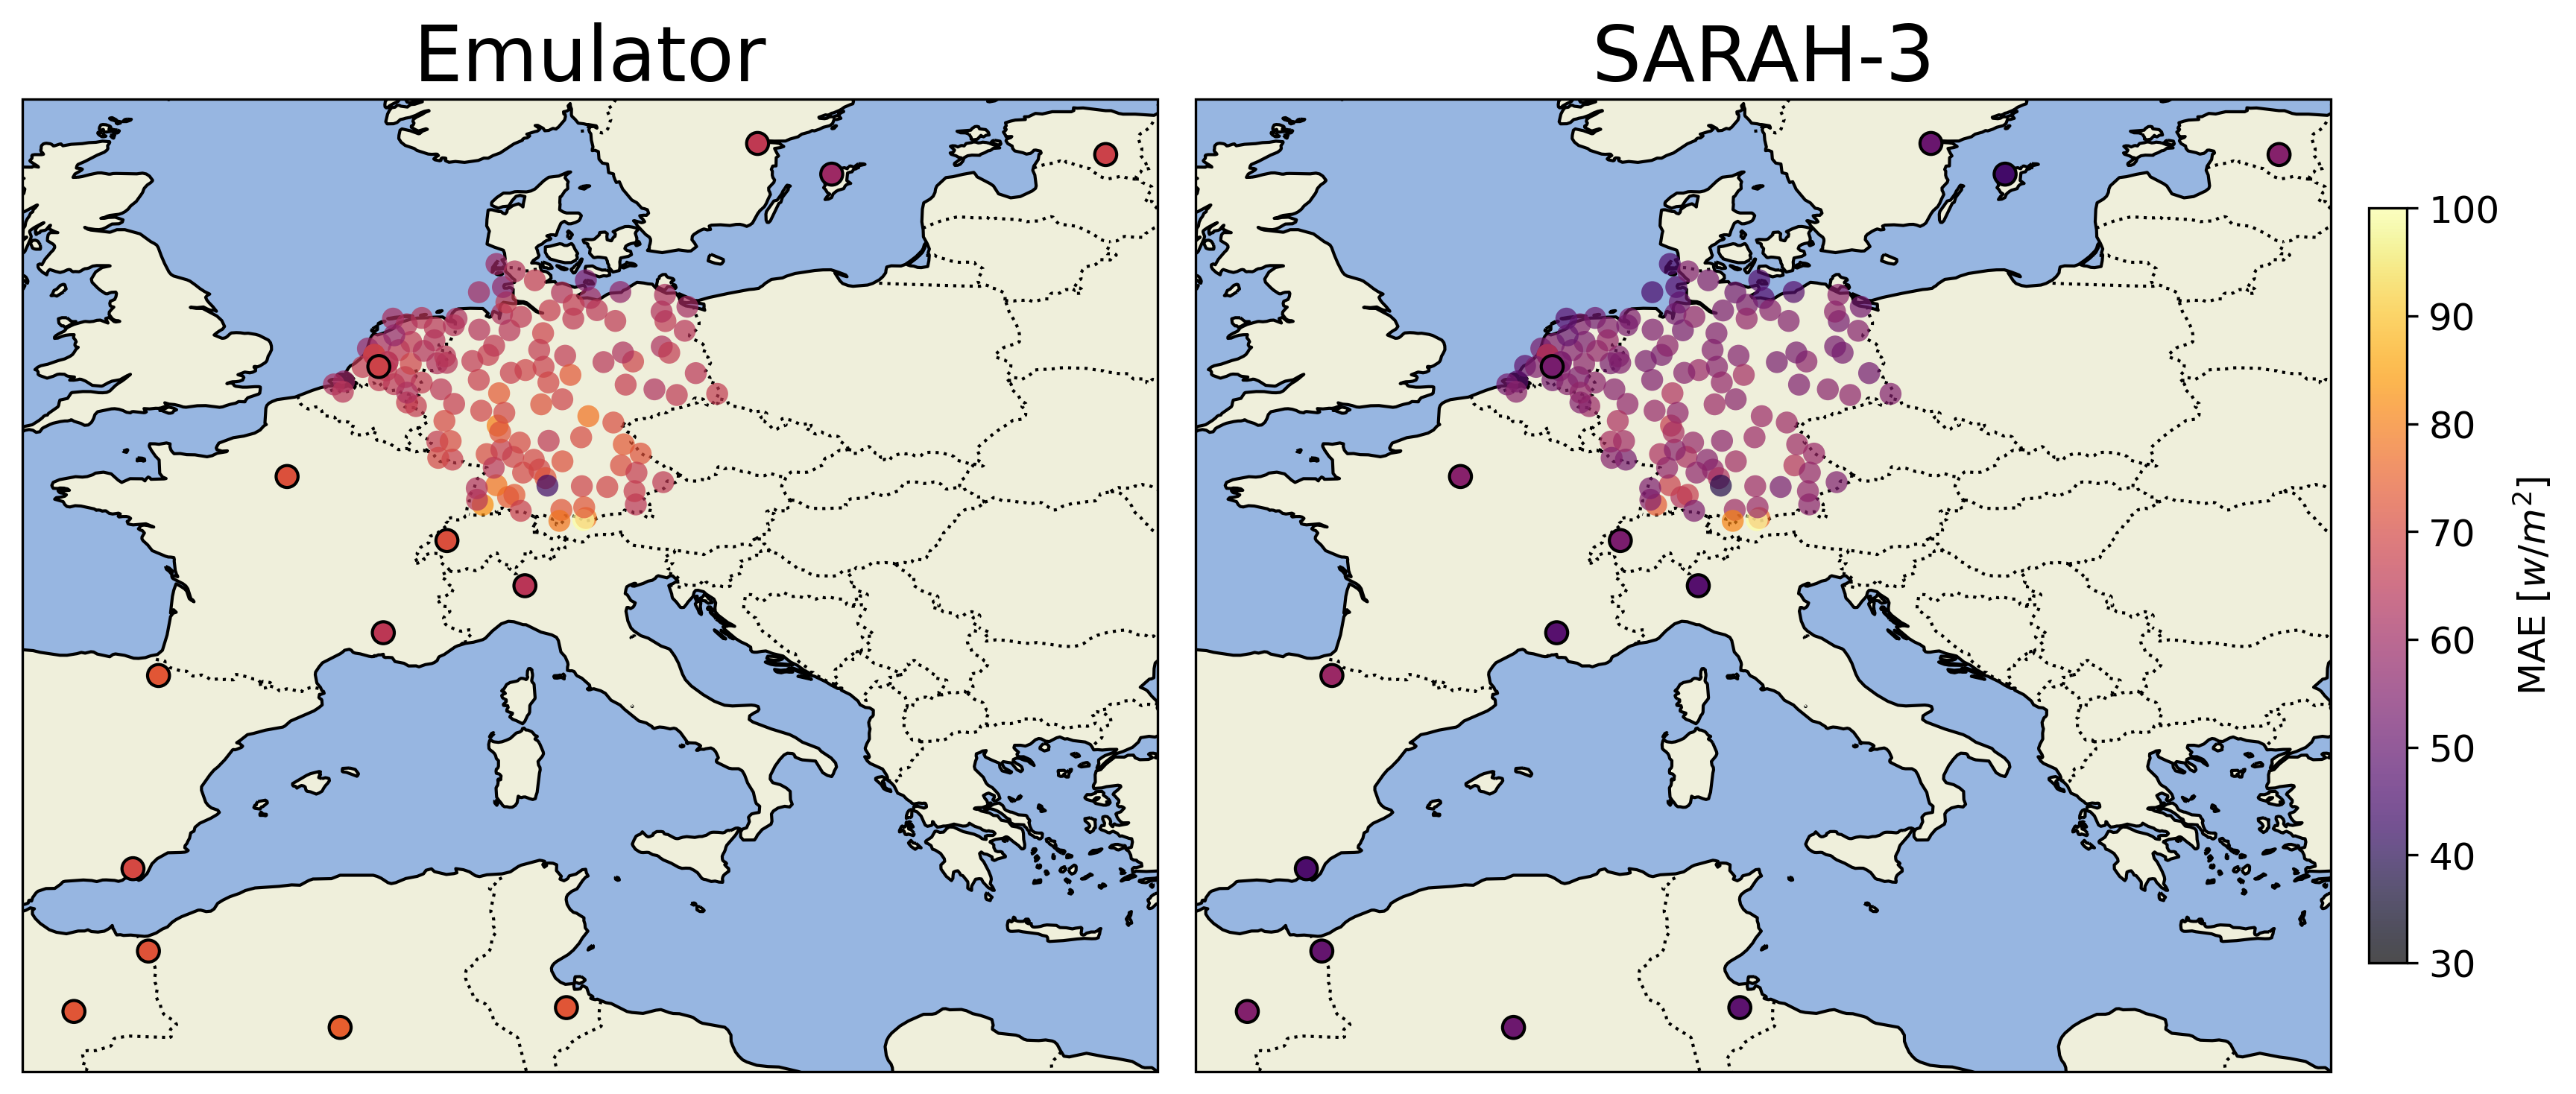

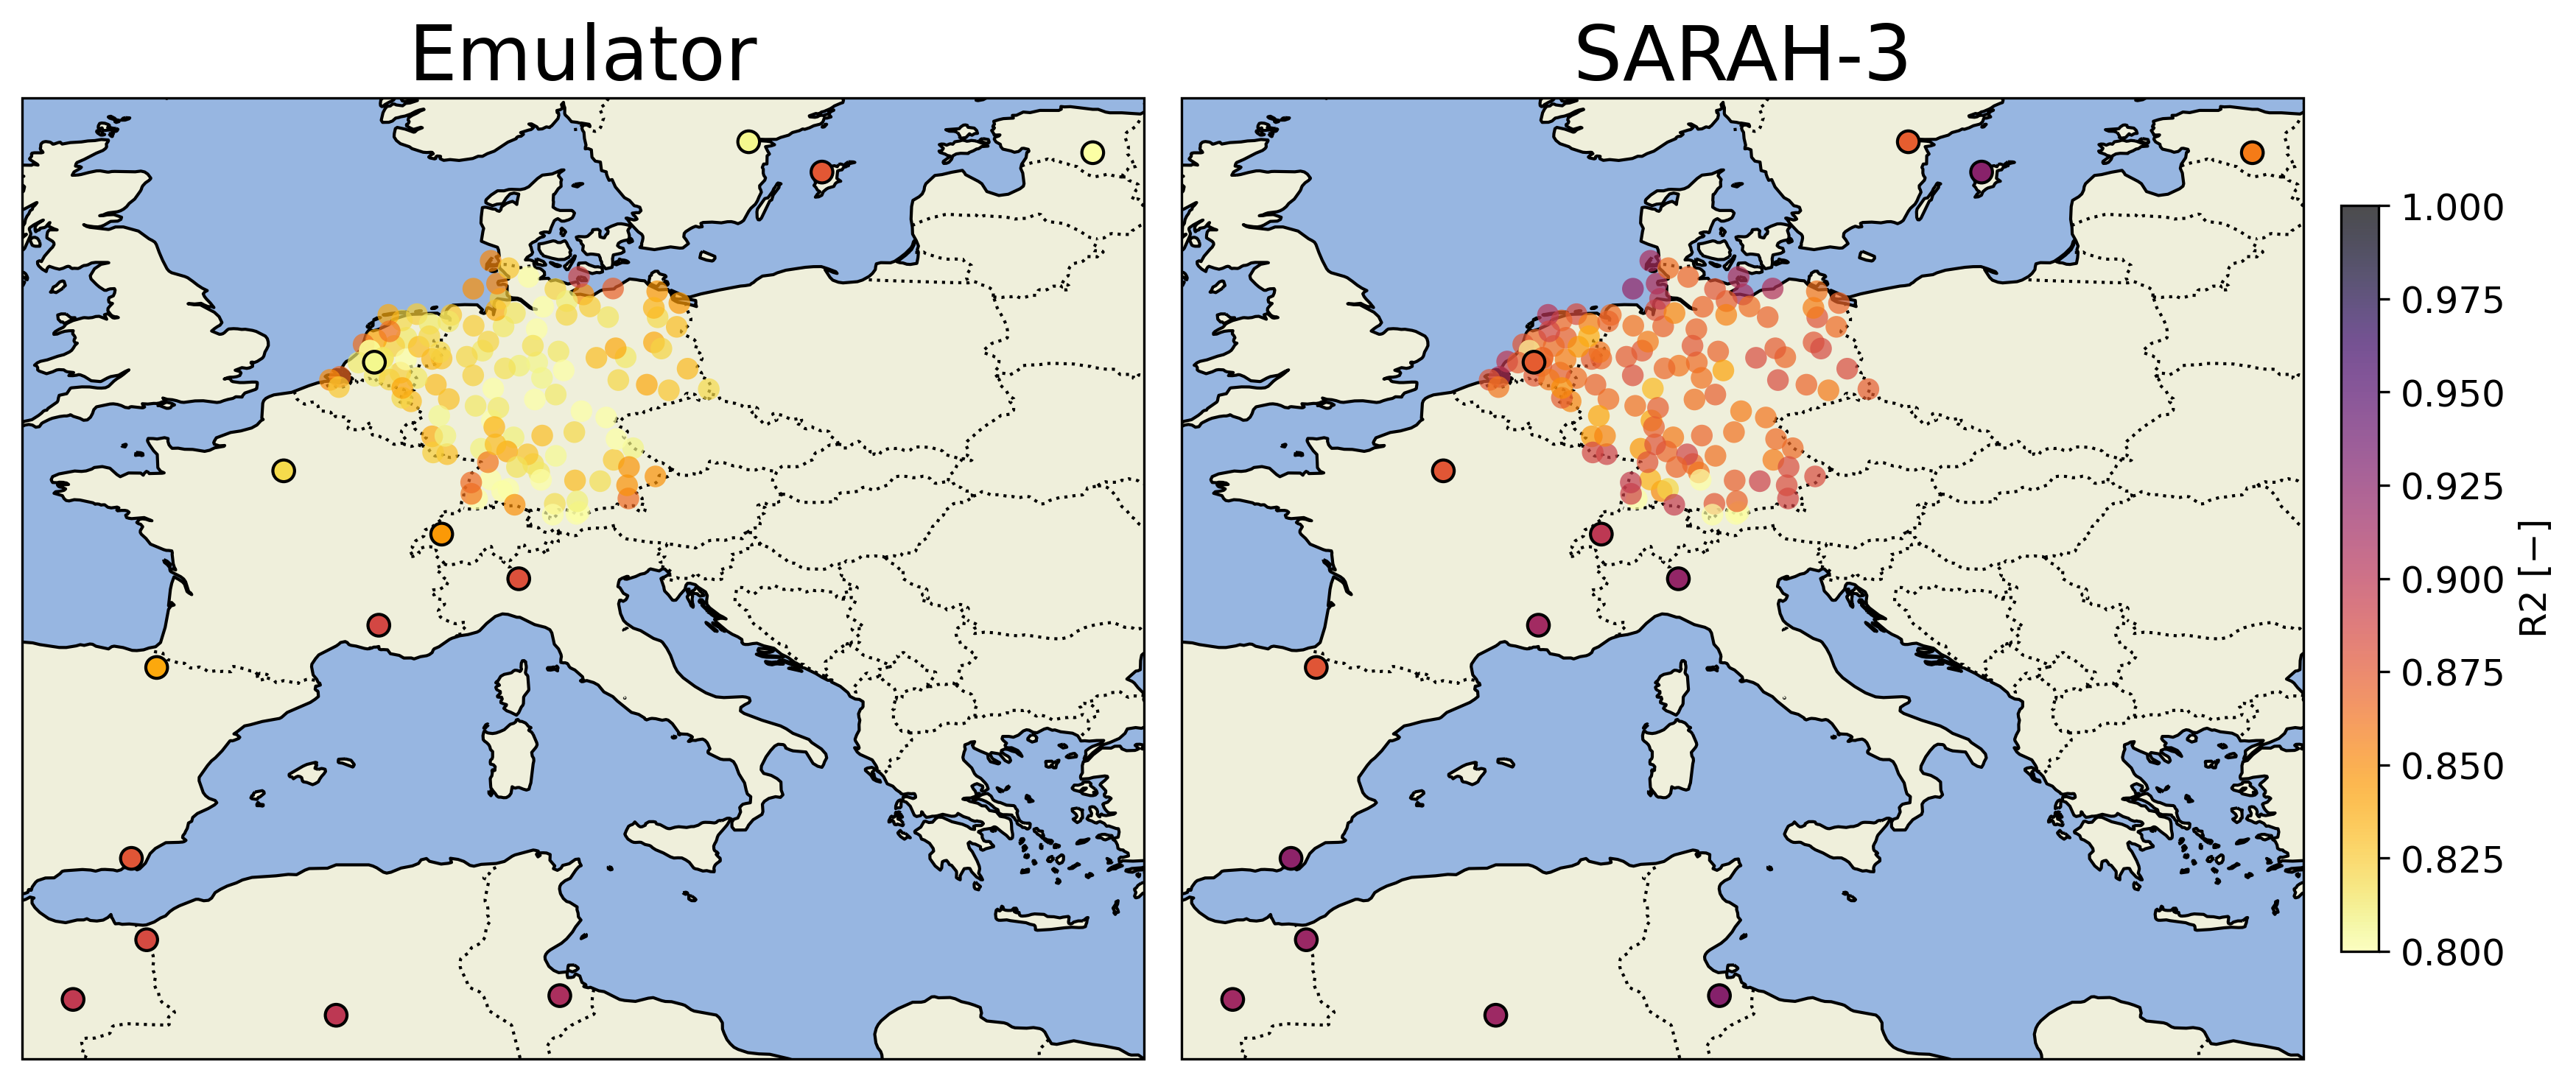

In [92]:
# inference_fn = '../train/SIS_point_estimation/4nbyae30/inference/'
# inference_fn = '../train/SIS_point_estimation_groundstation/pl86of1b/inference/'
# trans = {'jup3gn3n':'Emulator', # SARAH3 emulator
#     'hmobjerd':'Finetuned on\n DWD', #  trained on 80 DWD groundstations{}
#     '4j9y9tqb': 'Finetuned on\n DWD -> METEOSWISS',
#     'hg90jzjy': 'Finetuned on\n DWD -> METEOSWISS -> IEA-PVPS',
#     '6zy2qu70': 'Trained only on\n DWD',
#     }

model_code = 'jup3gn3n'
model_nm = trans[model_code]
inference_fn= model_folders[model_code] + 'inference/'

bsrn = xarray.open_dataset('../IEA_PVPS/index.nc')
bsrn['station'] = bsrn.station_name
bsrn = bsrn.assign_coords(lat=bsrn.latitude, lon=bsrn.longitude)

bsrn = bsrn.sel(station=[str(x) for x in baseline_BSRN.keys()])

dwd = xarray.open_dataset('../DWD/netcdf/DWD_SOLAR_index.nc')
dwd = dwd.sel(station_id=[int(x) for x in baseline_dwd.keys()])
dwd = dwd.rename({'station_id':'station'})
dwd = dwd.drop_vars(['altitude'])

knmi = xarray.open_dataset('../KNMI/nc/index.nc')
knmi = knmi.sel(station=list(baseline_knmi.keys()))
knmi = knmi.assign_coords(lat=knmi.lat, lon=knmi.lon)

meteoswiss = xarray.open_zarr('../METEOSWISS/ground_station_data.zarr')
meteoswiss =meteoswiss.sel(station_name=list(baseline_meteoswiss.keys()))
meteoswiss = meteoswiss.rename_vars({'x':'lon', 'y':'lat'}).set_coords(['lon', 'lat'])
meteoswiss = meteoswiss.rename_dims({'station_name':'station'}).rename_vars({'station_name':'station'})

all_sets = ['IEA_PVPS', 'DWD_train', 'DWD_valid', 'KNMI', 'METEOSWISS']
subset = ['IEA_PVPS', 'DWD_train', 'DWD_valid', 'KNMI',]

metrics  = []
for nm in subset:
    fn = inference_fn + f'{nm}_metrics.txt'
    a = pd.read_csv(fn, sep=';', index_col=0, comment='#', names=['station', 'bias', 'RMSE', 'MAE', 'R2'])
    metrics.append(a)

metrics = pd.concat(metrics)

metrics_baseline  = []
for nm in subset:
    if nm == 'DWD_valid':
        nm = 'DWD'
        ids = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]
    elif nm == 'DWD_train':
        nm = 'DWD'
        ids = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]

    fn = f'../irradiance_estimation/inference/{nm}_metrics_baseline.txt'
    if nm == 'DWD':
        a = pd.read_csv(fn, sep=';', index_col=0, comment='#', names=['station', 'bias', 'RMSE', 'MAE', 'R2']).loc[ids]
    else:
        a = pd.read_csv(fn, sep=';', index_col=0, comment='#', names=['station', 'bias', 'RMSE', 'MAE', 'R2'])
    metrics_baseline.append(a)

metrics_baseline = pd.concat(metrics_baseline)

station_latlon = xarray.concat([bsrn[['lat', 'lon']], dwd[['lat', 'lon']], knmi[['lat', 'lon']], meteoswiss[['lat', 'lon']]]
                               , dim='station' ).drop_duplicates(dim='station')

station_metrics = xarray.merge([metrics.to_xarray().drop_duplicates(dim='station'), station_latlon], join='inner', compat='override')

station_metrics_baseline = xarray.merge([metrics_baseline.to_xarray().drop_duplicates(dim='station'), station_latlon], join='inner', compat='override')

if model_code == 'pl86of1b':
    station_metrics = station_metrics.drop(train_id, dim='station')
    station_metrics_baseline = station_metrics_baseline.drop(train_id, dim='station')

# Create a Cartopy projection




for var in ['bias', 'RMSE', 'MAE', 'R2']:
    fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
    gs = fig.add_gridspec(
        3,
        3,
        width_ratios=(3, 3, .1),
        height_ratios=(1, 3, 1),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.1,
    )
    ax1 = fig.add_subplot(gs[:, 0], projection=proj)
    ax2 = fig.add_subplot(gs[:, 1], projection=proj, sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs[1, 2])
    # Add map features
    for ax in (ax1, ax2):
        ax.add_feature(cf.LAND, zorder=-2)
        ax.add_feature(cf.OCEAN, zorder=-2)
        ax.add_feature(cf.COASTLINE, zorder=-1)
        ax.add_feature(cf.BORDERS, linestyle=':', zorder=-1)

    cmap='inferno'
    unit = '[w/m^2]'
    size= 50
    var_nm = var
    if var == 'bias':
        var_nm = 'MBD'
        cmap='bwr'
        vmin = -40
        vmax = 3015
        norm = mpl_colors.Normalize(vmin=vmin, vmax=vmax)
    elif var == 'MAE':
        vmin=30
        vmax=100 
        norm = mpl_colors.Normalize(vmin=vmin, vmax=vmax)

    scatter = station_metrics.plot.scatter(x='lon', y='lat', hue=var,  s=size, alpha=.7, ax=ax1,
                                norm = norm, vmin=vmin, vmax=vmax, cmap=cmap, linewidths=0.001, 
                                edgecolors=None, transform=proj, add_colorbar=False)
    
    station_metrics.sel(station=list(baseline_BSRN.keys())).plot.scatter(x='lon', y='lat', hue=var,  s=size, alpha=1, ax=ax1,
                                norm = norm, vmin=vmin, vmax=vmax, cmap=cmap, linewidths=1, 
                                edgecolors='k', transform=proj, add_colorbar=False)
    
    ax1.set_title(f'{model_nm}')
    station_metrics_baseline.plot.scatter(x='lon', y='lat', hue=var,s=size, alpha=.7, ax=ax2,
                                norm = norm, cmap=cmap, vmin=vmin, vmax=vmax, linewidths=0.001, 
                                edgecolors=None,  transform=proj, add_colorbar=False)
    #highlight 
    station_metrics_baseline.sel(station=list(baseline_BSRN.keys())).plot.scatter(x='lon', y='lat', hue=var,  s=size, alpha=1, ax=ax2,
                                norm = norm, vmin=vmin, vmax=vmax, cmap=cmap, linewidths=1, 
                                edgecolors='k', transform=proj, add_colorbar=False)
    ax2.set_title('SARAH-3')
    plt.colorbar(cax=ax3, mappable=scatter, label=var_nm + ' ' + f'${unit}$')
    
    if subset == all_sets:
        fn = f'{var}_{model_code}_scatter.png'
    else:
        fn = f'{var}_{model_code}_' + '_'.join(subset) + '_scatter.png'
    plt.savefig(fn, dpi=DPI, bbox_inches='tight')


In [296]:
for var in station_metrics:
    if var in ['lat', 'lon']:
        continue
    var_diff = var + '_diff'

    station_metrics[var_diff] = station_metrics[var] - station_metrics_baseline[var]


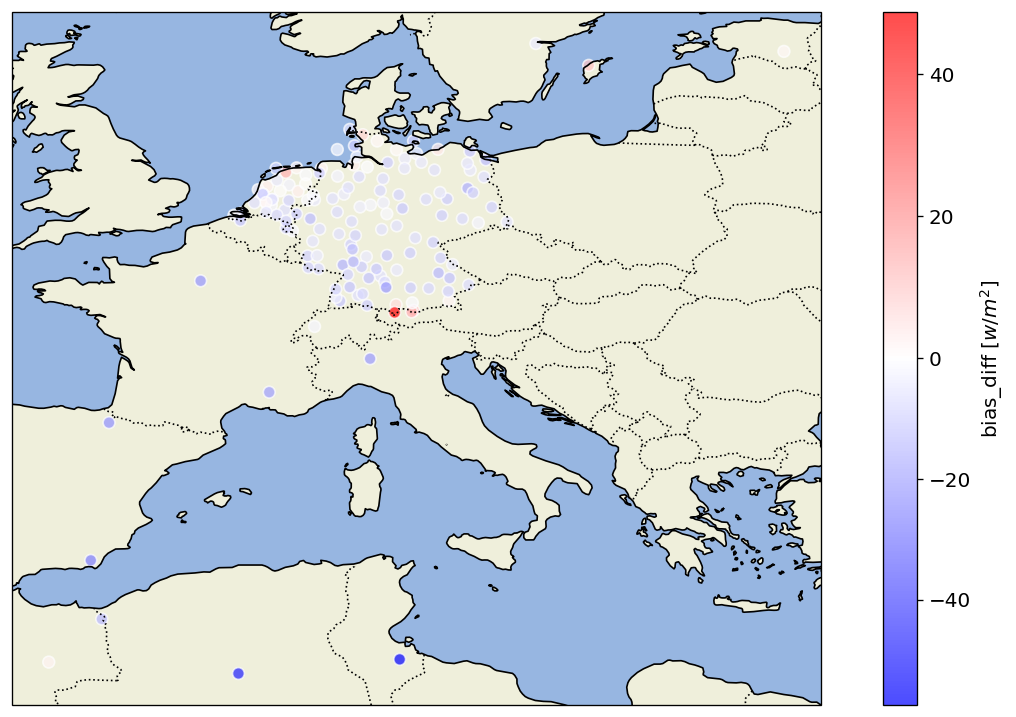

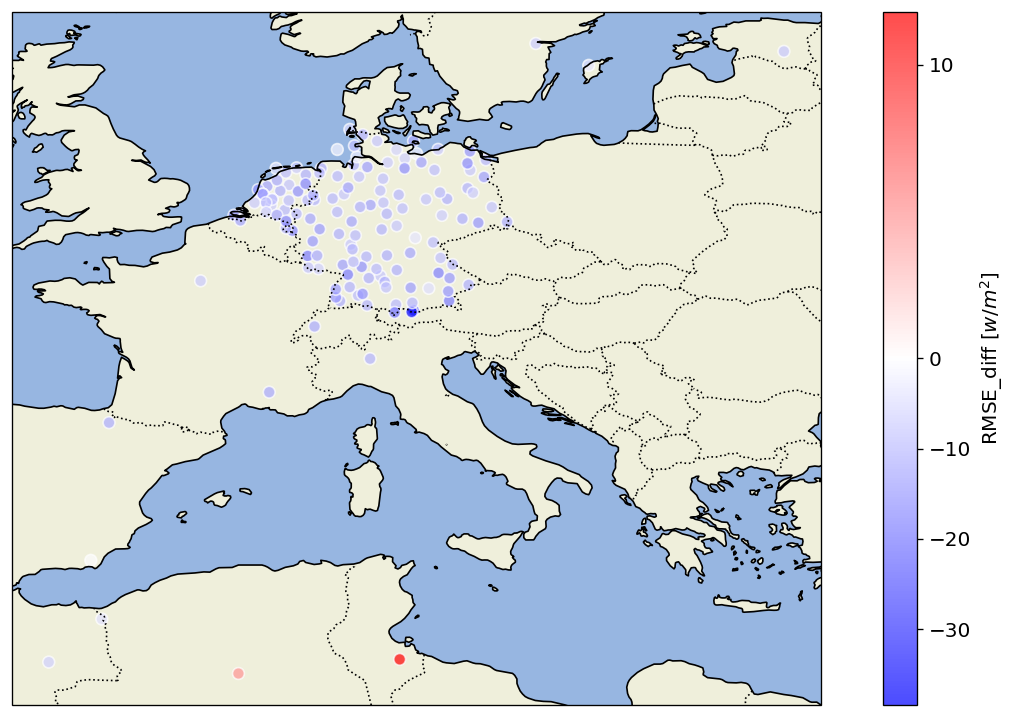

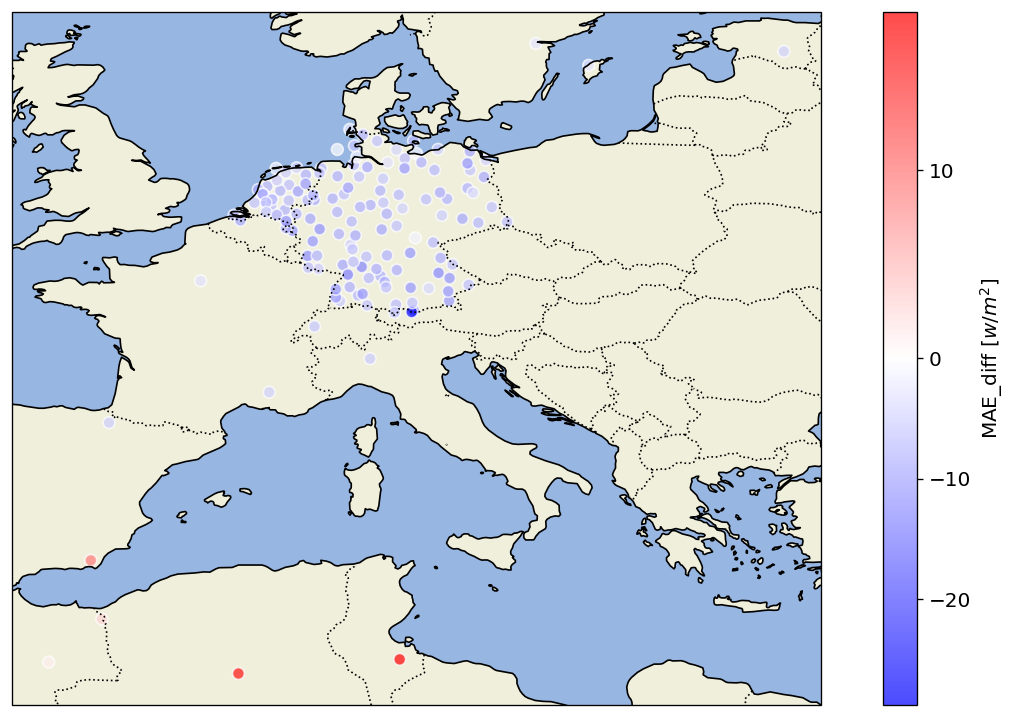

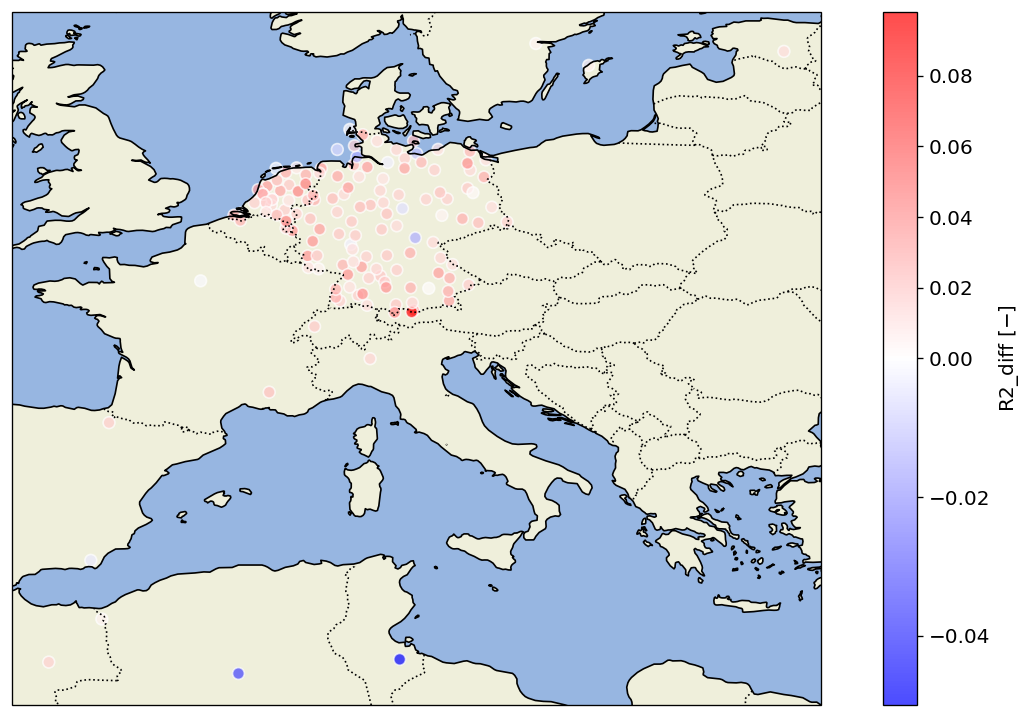

In [297]:

for var in station_metrics:
    if '_diff' not in var:
        continue

    fig = plt.figure(figsize=FIGSIZE, dpi=DPI, )
    ax = fig.add_subplot(projection=proj)

    if 'R2' in var:
        unit = '[-]'
    else:
        unit = '[w/m^2]'

    vmin = min([min(station_metrics[var]),-.01])
    vmax = max([max(station_metrics[var]), 0.01])
    norm = mpl_colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    scatter = station_metrics.plot.scatter(ax=ax, x='lon', y='lat', hue=var, norm=norm, cmap='bwr', s=size, alpha=.7, add_colorbar=False)
    # ax.set_title(f'Difference: {model_nm} and SARAH3')
    ax.add_feature(cf.LAND)
    ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.BORDERS, linestyle=':')
    plt.colorbar(scatter, label=f'{var} ${unit}$')
    # ax.set_title(trans[model_code].replace(r'\n', ' ') + ' - SARAH3')
    if subset == all_sets:
        fn = f'{var}_{model_code}.png'
    else:
        fn = f'{var}_{model_code}_' + '_'.join(subset) + '.png'
    fig.savefig(fn, dpi=DPI, bbox_inches='tight')

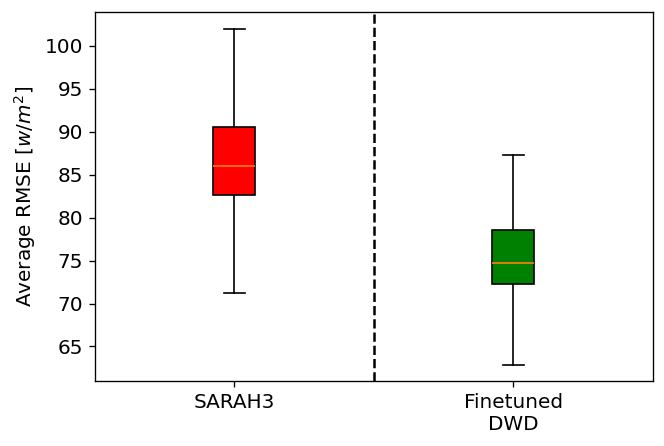

In [298]:
fig, axes = plt.subplots(1,1, figsize=(6,4), dpi=DPI)
bplot1 = axes.boxplot([station_metrics_baseline['RMSE'], station_metrics['RMSE']],
                      labels=[ 'SARAH3',model_nm], 
                    #   notch=True,
                    showfliers=False,
                      meanline=True,
                     patch_artist=True,  # fill with color
                     )
axes.set_ylabel('Average RMSE $[w/m^2]$')
axes.axvline(1.5, color = 'k', linestyle='--')
# axes.axhline(0, color = 'lightgrey', linestyle='--', zorder=-2)


# axes.set_title(f'{" ".join(subset)} ground observations')

colors = ['red', 'green', 'lightgreen', 'lightblue']
for bplot in (bplot1,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

if subset == all_sets:
    fn = f'boxplot_average_RMSE_{model_code}.png'
else:
    fn = f'boxplot_average_RMSE_{model_code}_' + '_'.join(subset) + '.png'

fig.savefig(fn)

In [272]:
station_metrics_baseline['RMSE']

<xarray.DataArray 'RMSE' ()>
array(203.4)
Coordinates:
    station  <U3 'ZER'
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>

In [275]:
station_metrics['bias'] - station_metrics_baseline['bias']

<xarray.DataArray 'bias' (station: 279)>
array([-1.49999998e+01,  1.00000000e+01, -1.81999999e+01, -1.38000000e+01,
        3.99999809e-01,  6.00000019e+00, -2.44000000e+01, -8.40000010e+00,
        1.47999996e+01,  8.90000005e+00, -1.30000001e+01, -1.70999999e+01,
       -1.84000000e+01, -1.10000000e+01,  5.90000038e+00,  1.35000000e+01,
       -1.79999990e+00,  5.99999962e+00,  8.00000095e-01, -3.79999962e+00,
        5.00000000e-01, -2.30000076e+00,  2.69999981e+00,  1.11000008e+01,
       -3.90000000e+00, -3.59999990e+00,  1.31999992e+01,  1.19999981e+00,
        1.90999998e+01,  3.40000038e+00,  1.67000008e+01,  8.10000000e+00,
        1.06000001e+01,  6.70000038e+00,  6.19999962e+00,  4.09999990e+00,
        8.89999981e+00,  1.00000095e-01, -1.30000000e+00, -9.79999995e+00,
       -1.52000004e+01,  2.69999924e+00, -9.00000191e-01, -1.60000000e+00,
        6.00000019e+00,  9.19999981e+00,  2.90000019e+00,  8.90000038e+00,
        5.90000000e+00,  7.30000000e+00,  2.28000008e+01,  9.60000000e+00,
        1.16999996e+01, -9.09999981e+00,  4.60000038e+00, -1.18000001e+01,
       -5.99999905e-01,  2.01000000e+01,  4.20000000e+00,  5.10000019e+00,
        6.79999924e+00,  1.27000004e+01,  1.28999992e+01,  8.80000038e+00,
       -1.45000002e+01,  5.00000381e-01,  4.00000000e+00, -6.99999809e-01,
        7.10000019e+00,  8.00000095e-01, -8.99999619e-01,  1.20000010e+00,
        8.99999809e-01, -1.69999981e+00,  1.00000019e+00,  1.09999996e+01,
        9.00000000e-01,  3.69999962e+00, -1.89999962e+00,  2.19999990e+00,
...
        1.51000000e+01,  5.34999985e+01,  3.99999905e-01,  4.80000000e+01,
        4.52000000e+01,  2.28000008e+01,  9.99999976e-01,  3.11000000e+01,
        7.30000000e+00,  3.53000031e+01, -1.00000010e+00,  4.42999985e+01,
       -1.30000002e+01, -1.70000000e+00,  2.43999998e+01,  1.61000004e+01,
        0.00000000e+00,  4.60000008e+01,  3.99999619e-01,  6.99999924e+00,
        2.49999996e+01,  9.99996185e-02,  4.00000381e-01,  4.59999995e+00,
        9.09999995e+00,  4.60000004e+01,  8.80000038e+00,  1.92999985e+01,
        1.70000000e+01,  4.85999985e+01, -1.09999981e+00,  4.49999962e+00,
        3.25999996e+01,  4.20000019e+00,  2.81000000e+01,  1.31000004e+01,
       -3.69999990e+00,  4.89999985e+01,  7.35000008e+01,  6.37000031e+01,
       -3.80000038e+00,  1.44000015e+01,  4.12000000e+01,  7.02000015e+01,
        5.38999985e+01, -9.99999809e-01,  1.35000002e+01,  3.59999962e+00,
        5.99999981e+00,  1.69999998e+01,  2.13999996e+01,  3.51000008e+01,
        6.00000000e+01,  3.60000038e+00,  1.53000004e+01,  2.82999992e+01,
        2.29999962e+00,  4.98000000e+01,  7.19999981e+00, -4.10000000e+00,
        1.42999996e+01,  4.05999985e+01,  1.23599998e+02,  4.24000031e+01,
        1.00000000e-01,  1.21500003e+02,  1.28100000e+02,  3.13000008e+01,
        8.49999962e+00,  5.06999985e+01,  5.81000008e+01,  1.55999998e+01,
       -5.80000010e+00,  2.78999999e+01,  2.97999996e+01,  8.16999999e+01,
        3.89999962e+00,  6.00000038e+00,  1.69000004e+01])
Coordinates:
  * station  (station) object 'TAB' 'PAY' 'CAR' 'MIL' ... 'INT' 'LEI' 'PIL'
    lat      (station) float64 37.09 46.81 44.08 45.48 ... 46.67 47.6 46.98
    lon      (station) float64 -2.358 6.944 5.059 9.255 ... 7.867 8.183 8.25

# Pyranometer performance Emulator

# SIS comparison


In [ ]:
model_nm =  'pl86of1b' # '4nbyae30'

fns = glob(f'../train/SIS_point_estimation_groundstation/{model_nm}/inference/image_predictions/predictions_2022*.pkl')
fn = fns[0]
print(os.path.basename(fn))
image = pickle_read(fn)
sarah3= image['sarah3']
dl = image['dl']

In [ ]:
a = model_predictions[model_nm]['BSRN']
station_metrics_temp = station_metrics.copy()
errors = {}

for set_nm, set in model_predictions.items():
    for key, val in a.items():
        idx = np.argwhere(val['time']==sarah3.time.values)
        y = val['y'][idx]
        y_hat = val['y_hat'][idx]
        if len(idx)>0:
            err_key = (y_hat - y).squeeze().item()
            errors[key] = err_key
        else:
            errors[key] = np.nan

stations_error = station_metrics_temp.sel(station=list(errors.keys()))
stations_error['error'] = ('station', list(errors.values()))

In [ ]:
a = baseline_prediction['BSRN']
errors_sarah= {}
for nm_set in ['BSRN', 'DWD train', 'DWD validation', 'KNMI']:
    for key, val in baseline_prediction[nm_set].items():
        combined = val['combined']
        print(combined)
        
        if (combined.time.values == sarah3.time.values).any():
            combined = combined.sel(time=sarah3.time.values)
            y = combined['SIS'].values
            y_hat = combined.channel_data[-1].values
            errors_sarah[key] = (y_hat - y).squeeze().item()
        else:
            errors_sarah[key] = np.nan


# stations_error_sarah = station_metrics_temp.sel(station=list(errors_sarah.keys()))
a = [np.argwhere(x==station_metrics_temp.station.values)[0][0] for x in errors_sarah.keys() if x in station_metrics_temp.station.values]
stations_error_sarah = station_metrics_temp.isel(station=a)
stations_error_sarah['error'] = ('station', list(errors_sarah.values()))

In [ ]:

time = sarah3.time.dt.strftime('%Y%m%d_%H%M').item()
time_pretty = sarah3.time.dt.strftime('%Y-%m-%d %H:%M').item()
proj = ccrs.PlateCarree()
FIGSIZE=(13.33,7.5)
DPI=120
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
gs = fig.add_gridspec(
    2,
    2,
    width_ratios=(3, 3),
    height_ratios=(3,.125),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.1,
)
ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax2 = fig.add_subplot(gs[0, 1], projection=proj, sharex=ax1, sharey=ax1)
# ax3 = fig.add_subplot(gs[0, 2], projection=proj, sharex=ax1, sharey=ax1)
axc1 = fig.add_subplot(gs[1, 0], autoscale_on=False)


# ax_text = fig.add_subplot(gs[1,1])
# ax_text.axis('off')
# ax_text.annotate(time_pretty, 
#             xycoords='axes fraction',
#             xy=[.3, .5])

dl.plot.imshow(x='lon', y='lat', 
                vmin=0, vmax=1100, 
                ax=ax1, transform=proj, add_colorbar=False)
sarah3.plot.imshow(x='lon', y='lat', 
                    vmin=0, vmax=1100, ax=ax2, 
                    transform=proj, cbar_ax=axc1,
                    cbar_kwargs={'orientation':'horizontal', 'shrink':0.6, 'aspect':40,'label':'SIS [W/m2]'})

vmin_error = min(stations_error['error'].min(), stations_error_sarah['error'].min())
vmax_error = max(stations_error['error'].max(), stations_error_sarah['error'].max())
            
norm = mpl_colors.TwoSlopeNorm(vmin=vmin_error, vcenter=0, vmax=vmax_error)


if sum(~np.isnan(list(errors_sarah.values()))) >0:
    scatter = ax1.scatter(x=stations_error['lon'].values, y=stations_error['lat'].values, c=stations_error['error'].values, s=100, 
                norm=norm, cmap='bwr', transform=proj)

    ax2.scatter(x=stations_error_sarah['lon'], y=stations_error_sarah['lat'], c=stations_error_sarah['error'].values, s=100,
                norm=norm, cmap='bwr', transform=proj, facecolor='none')

    axc2 = fig.add_subplot(gs[1, 1])
    plt.colorbar(scatter, cax=axc2, orientation='horizontal', label='Error [W/m2]')

# error = output_image - ground_truth_image.reindex_like(output_image, method="nearest")
# error.plot.imshow(ax=ax3, transform=proj, cbar_ax=axc2)
ax1.set_title("DL")
ax2.set_title("SARAH3")
# ax3.set_title("$\hat{y} - y$")

gls = {}
for i, ax in enumerate([ax1,ax2]):
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=.3)
    gl.top_labels = False
    gl.right_labels = False
    if i>0:
        gl.left_labels = False

In [ ]:
stations_error_sarah['lat'].values